In [1]:
import pandas as pd
import os
import numpy as np
from keras.preprocessing import timeseries_dataset_from_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import timeseries_dataset_from_array
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR


2024-12-07 01:15:28.983813: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
class DataPreprocess:
    def __init__(self):
        pass

    def load_data(self, path):
        df = pd.read_csv(path)
        df.drop("Unnamed: 0", inplace=True, axis = 1)
        return df

    def get_bid_levels(self, df, bid_levels):
        df_tmp = pd.DataFrame()
        df_tmp['time'] = pd.to_datetime(df['system_time'])
        df_tmp['midpoint'] = df['midpoint']
        
        # Filter ask and bid volume columns
        ask_cols = [f'asks_limit_notional_{i}' for i in range(bid_levels)]
        bid_cols = [f'bids_limit_notional_{i}' for i in range(bid_levels)]
        ask_cols = [col for col in ask_cols if col in df.columns]
        bid_cols = [col for col in bid_cols if col in df.columns]
        
        # Assign ask and bid volumes
        for lvls in range(len(ask_cols)):  # Use the length of filtered columns
            df_tmp[f'ask_volume{lvls}'] = df[ask_cols[lvls]]
        for lvls in range(len(bid_cols)):  # Use the length of filtered columns
            df_tmp[f'bid_volume{lvls}'] = df[bid_cols[lvls]]
        
        # Filter ask and bid distance columns
        ask_distance_cols = [f'asks_distance_{i}' for i in range(bid_levels)]
        bid_distance_cols = [f'bids_distance_{i}' for i in range(bid_levels)]
        ask_distance_cols = [col for col in ask_distance_cols if col in df.columns]
        bid_distance_cols = [col for col in bid_distance_cols if col in df.columns]
        
        # Assign ask and bid prices
        for lvls in range(len(ask_distance_cols)):  # Use the length of filtered columns
            df_tmp[f'ask_price{lvls}'] = df['midpoint'] + (df['midpoint'] * df[ask_distance_cols[lvls]])
        for lvls in range(len(bid_distance_cols)):  # Use the length of filtered columns
            df_tmp[f'bid_price{lvls}'] = df['midpoint'] + (df['midpoint'] * df[bid_distance_cols[lvls]])
        return df_tmp

    """
        For a actively traded stock,
        1. If there is an increase in the bid price in future compared to its current or previous value.
            We take the Bid volume.
        2. If the previous and current price is same we take the difference in the volume.
        3. If the current price is less than the current one then we take -ve of the current volume.

        Order Flow Imbalance is actually a factor that denotes the buying side or selling pressue for a particular stock at that level.
        When OFI > 0 it means that market is dominated by sellers. Lot more bids have happened.
        When OFI < 0 it means that market is dominated by buyers. Lot more asks have happened.
    """
    def get_bid_with_ofi_levels(self, df_tmp, bid_levels):
        for lvls in range(bid_levels):
            bid_price = df_tmp[f'bid_price{lvls}']
            ask_price = df_tmp[f'ask_price{lvls}']
            bid_volume = df_tmp[f'bid_volume{lvls}']
            ask_volume = df_tmp[f'ask_volume{lvls}']
            
            # Shift prices and volumes to compute differences
            bid_price_prev = bid_price.shift(1)
            ask_price_prev = ask_price.shift(1)
            bid_volume_prev = bid_volume.shift(1)
            ask_volume_prev = ask_volume.shift(1)
            
            # Calculate bid and ask order flows
            bid_of = np.where(
                bid_price > bid_price_prev, bid_volume,
                np.where(bid_price == bid_price_prev, bid_volume - bid_volume_prev, -bid_volume)
            )
            ask_of = np.where(
                ask_price > ask_price_prev, -ask_volume,
                np.where(ask_price == ask_price_prev, ask_volume - ask_volume_prev, ask_volume)
            )
            
            # Calculate OFI
            df_tmp[f'ofi_level{lvls}'] = bid_of - ask_of
        return df_tmp

    
    def make_window(self, window_size, dataframe, partition):
        normalized_df = df_new.to_numpy()
        dataframe.drop("time", inplace=True, axis = 1)
        train_length = int(len(normalized_df) * partition)
        data_length = len(normalized_df)
        
        midpoint_idx = df_new.columns.get_loc("midpoint")
        
        windows_train = timeseries_dataset_from_array(
            normalized_df[:train_length],  # Features for training
            normalized_df[window_size:train_length + window_size, midpoint_idx],  # Labels for training
            window_size,
            sequence_stride=1,
            sampling_rate=1,
            batch_size=64,
            shuffle=False,
            seed=None
        )
        
        # Windows for test dataset
        windows_test = timeseries_dataset_from_array(
            normalized_df[train_length:data_length - window_size],  # Features for testing
            normalized_df[train_length + window_size:, midpoint_idx],  # Labels for testing
            window_size,
            sequence_stride=1,
            sampling_rate=1,
            batch_size=64,
            shuffle=False
        )
        return windows_train, windows_test

    """
        Returns x_train, y_train, x_test, y_test
    """
    def make_generic_window(self, window_size, df, partition, make_window=False):
        feature_columns = [col for col in df.columns if col != 'midpoint' and col != 'time']
        X, y = [], []

        if make_window:
            # Create sliding windows
            for i in range(len(df) - window_size):
                X.append(df.iloc[i:i + window_size][feature_columns].values)
                y.append(df.iloc[i + window_size]['midpoint'])
            
            X = np.array(X)
            y = np.array(y)
            split_point = int(len(df)*partition)
            X_train = X[:split_point]
            X_test = X[split_point:]
            y_train = df.iloc[:split_point]['midpoint']
            y_test =  df.iloc[split_point:]['midpoint']
            return X_train, X_test, y_train, y_test
        else:
            split_point = int(len(df)*partition)
            X_train = X[:split_point]
            X_test = X[split_point:]
            y_train = df.iloc[:split_point]['midpoint']
            y_test =  df.iloc[split_point:]['midpoint']
            
            return X_train, X_test, y_train, y_test

    def normalize_data(self, df, train_length):
        """
        Normalizes data based on the training dataset mean and std.
        """
        if "time" in df.columns:
            df = df.drop(columns=["time"])
        mean_df = df[:train_length].mean()
        std_df = df[:train_length].std()
        normalized_df = (df - mean_df) / std_df
        return normalized_df

    # Function to extract data from TensorFlow Dataset
    def extract_data_from_dataset(self, dataset):
        X_list = []
        y_list = []
        for X_batch, y_batch in dataset:
            X_list.append(X_batch.numpy())
            y_list.append(y_batch.numpy())
        X_array = np.vstack(X_list)  # Combine batches into one array
        y_array = np.concatenate(y_list)
        return X_array, y_array

    def r_get_window(self, normalized_df, df_tmp, train_length, window_size):
        # Drop time column (not needed for input features)
        df_tmp = df_tmp.drop(columns=["time"])
        
        # Split dataset into train and test sets
        data_length = df_tmp.shape[0]
        train_length = round(0.8 * data_length)  # 80% training data
        
        normalized_df = dp.normalize_data(df_tmp, train_length)

        data_array = normalized_df.to_numpy()
        
        X = data_array[:, 1:]  # All columns except the first ('midpoint')
        y = df_tmp["midpoint"]
        #y = data_array[:, 0]   # The first column is 'midpoint'
        
        windows_train = timeseries_dataset_from_array(
            X[:train_length],                    # Features for training
            y[window_size:(train_length+window_size)],  # Target (midpoint) for training
            sequence_length=window_size,        # Length of each input sequence
            sequence_stride=1,                  # Step size for creating sequences
            sampling_rate=1,                    # Sample every time step
            batch_size=64,                      # Batch size
            shuffle=False                        # Shuffle training data
        )
        
        # Windows for test dataset
        windows_test = timeseries_dataset_from_array(
            X[train_length:(data_length-window_size)],  # Features for testing
            y[train_length + window_size:],            # Target (midpoint) for testing
            sequence_length=window_size,               # Length of each input sequence
            sequence_stride=1,                         # Step size for creating sequences
            sampling_rate=1,                           # Sample every time step
            batch_size=64,                             # Batch size
            shuffle=False                              # Do not shuffle test data
        )
        
        return windows_train, windows_test

    # Function to extract data from TensorFlow Dataset
    def extract_data_from_dataset(self, dataset):
        X_list = []
        y_list = []
        for X_batch, y_batch in dataset:
            X_list.append(X_batch.numpy())
            y_list.append(y_batch.numpy())
        X_array = np.vstack(X_list)  # Combine batches into one array
        y_array = np.concatenate(y_list)
        return X_array, y_array

    def plot_graph(self, y_test, y_pred):
        # Plotting the graphs
        plt.figure(figsize=(10, 6))
        plt.plot(y_test, label="Actual", color="blue")
        plt.plot(y_pred, label="Predicted", color="red", linestyle="--")
        plt.legend()
        plt.title("Actual vs Predicted Values")
        plt.xlabel("Sample Index")
        plt.ylabel("Target Value")
        plt.show()

    def get_metrics(self, y_test, y_pred):
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        print(f"Mean Squared Error: {mse}")
        print(f"R² Score: {r2}")
        
        dp.plot_graph(y_test, y_pred)

In [3]:
dp = DataPreprocess()

df = dp.load_data('archive/ETH_1min.csv')

In [8]:
def train_model_and_get_result(lvls, window_size, C=0.1, is_ofi=True):
    df_one = dp.get_bid_levels(df, lvls)
    df_one.head()
    
    if is_ofi:
        df_one = dp.get_bid_with_ofi_levels(df_one, lvls)
        
    data_length = df_one.shape[0]
    train_length = round(0.8*data_length)
    
    normalized_df = dp.normalize_data(df_one, train_length)
    windows_train, windows_test = dp.r_get_window(normalized_df, df_one, train_length, window_size)
    
    # Extract training data
    X_train, y_train = dp.extract_data_from_dataset(windows_train)
    
    # Extract testing data
    X_test, y_test = dp.extract_data_from_dataset(windows_test)
    
    
    # Flatten training and testing data
    X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Flatten each window
    X_test_flat = X_test.reshape(X_test.shape[0], -1)
    
    # Initialize scaler
    scaler = StandardScaler()
    
    # Fit and transform training data
    X_train_scaled = scaler.fit_transform(X_train_flat)
    
    # Transform testing data
    X_test_scaled = scaler.transform(X_test_flat)
    
    
    # Initialize SVR with RBF kernel
    svr_model = SVR(kernel='rbf', C=C, epsilon=0.1)

    # Train the SVR model
    svr_model.fit(X_train_scaled, y_train)

    y_pred = svr_model.predict(X_test_scaled)
    dp.get_metrics(y_test, y_pred)

metrics for  lvl -  3 window -  25 c -  1 ofi -  True


2024-12-07 01:20:39.455896: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 01:20:39.692956: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1480.4745433830033
R² Score: 0.8967290599039006


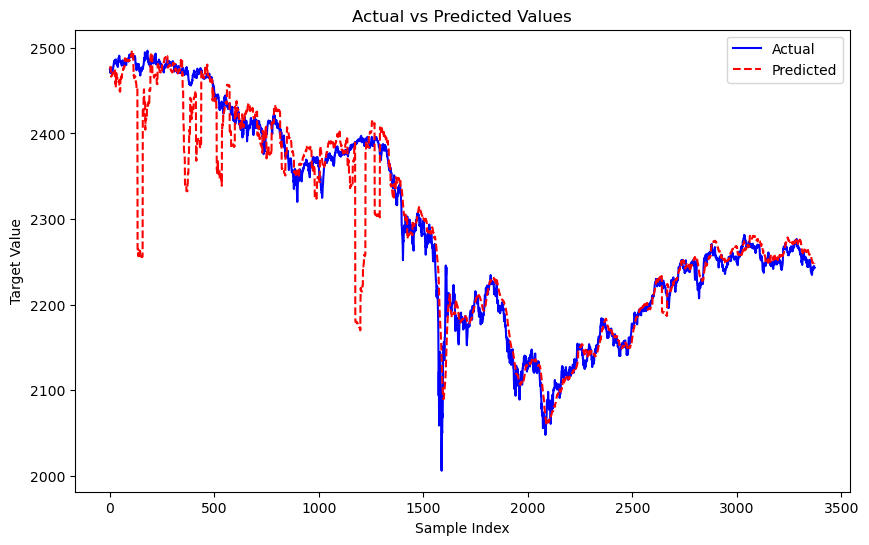

metrics for  lvl -  3 window -  25 c -  1 ofi -  False


2024-12-07 01:21:43.956812: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 01:21:44.156058: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1138.6806475956498
R² Score: 0.9205709942990783


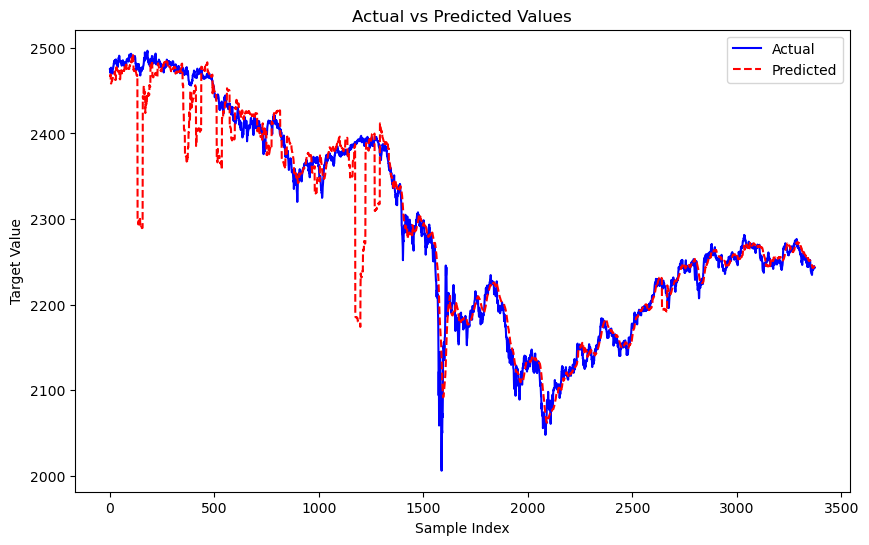

metrics for  lvl -  5 window -  25 c -  1 ofi -  True


2024-12-07 01:22:38.942649: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 01:22:39.229912: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1950.380546318764
R² Score: 0.8639506275445796


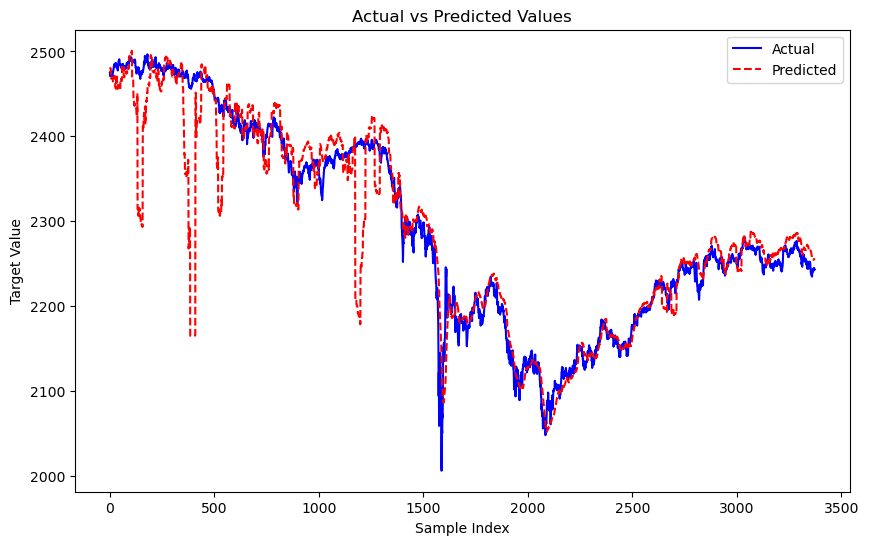

metrics for  lvl -  5 window -  25 c -  1 ofi -  False


2024-12-07 01:24:23.508914: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 01:24:23.744391: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1612.661281136989
R² Score: 0.887508334875494


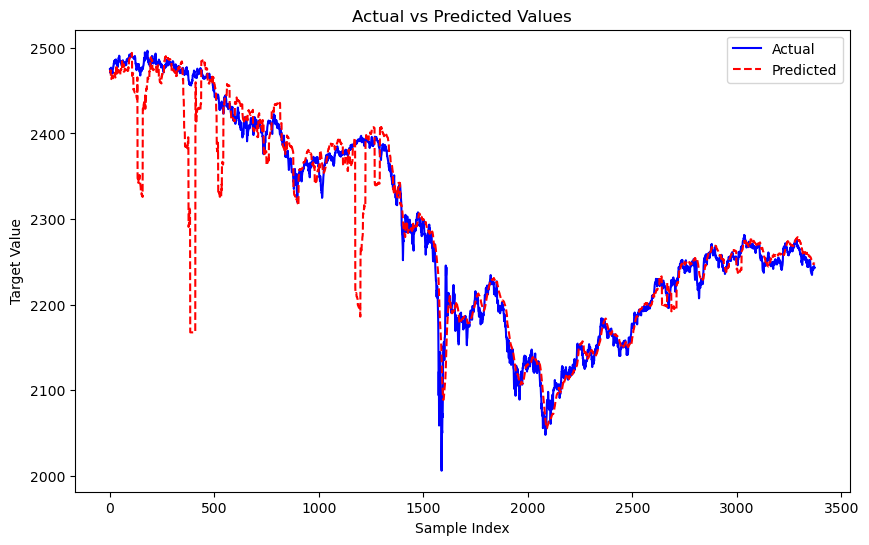

metrics for  lvl -  10 window -  25 c -  1 ofi -  True


2024-12-07 01:25:54.094827: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 01:25:54.410255: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 2352.1493592729107
R² Score: 0.8359251250457266


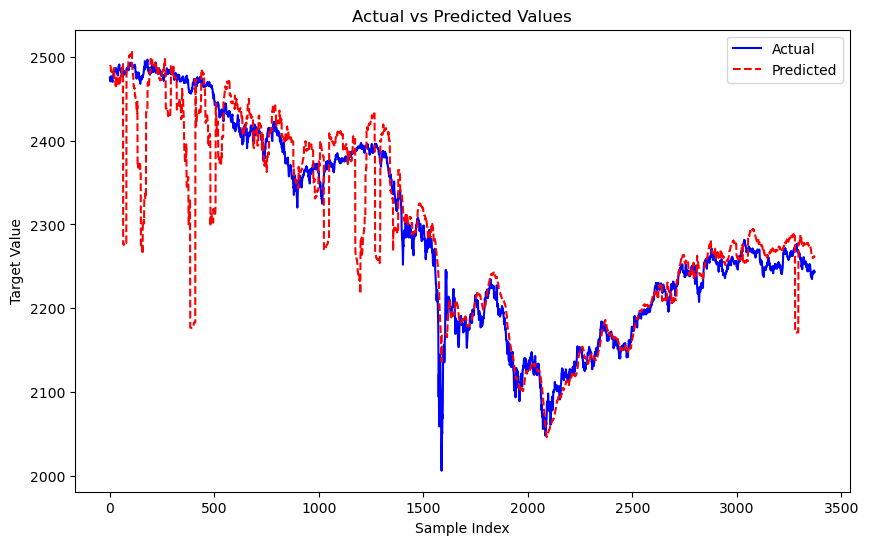

metrics for  lvl -  10 window -  25 c -  1 ofi -  False


2024-12-07 01:28:56.679784: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 01:28:56.989467: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1907.5752901204617
R² Score: 0.8669365208639959


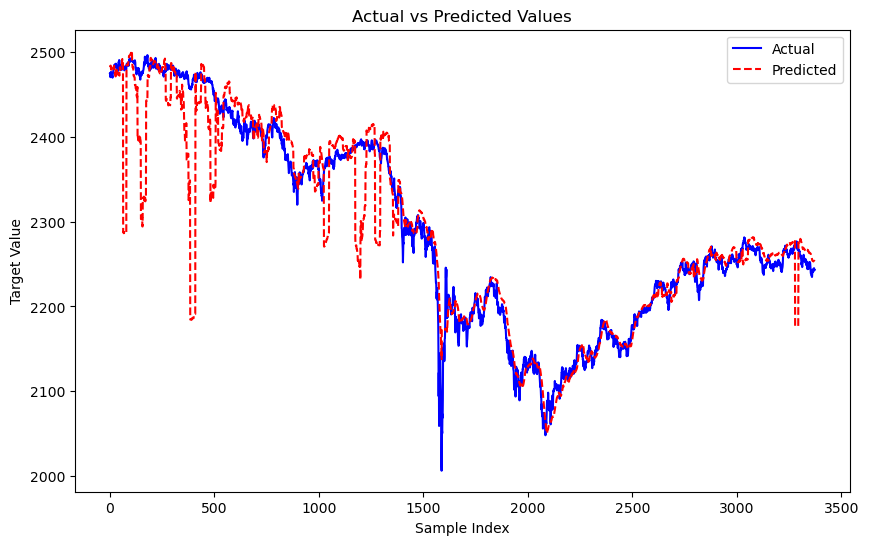

metrics for  lvl -  3 window -  50 c -  1 ofi -  True


2024-12-07 01:31:17.179788: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 01:31:17.418841: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1539.1434552437395
R² Score: 0.8921798885279231


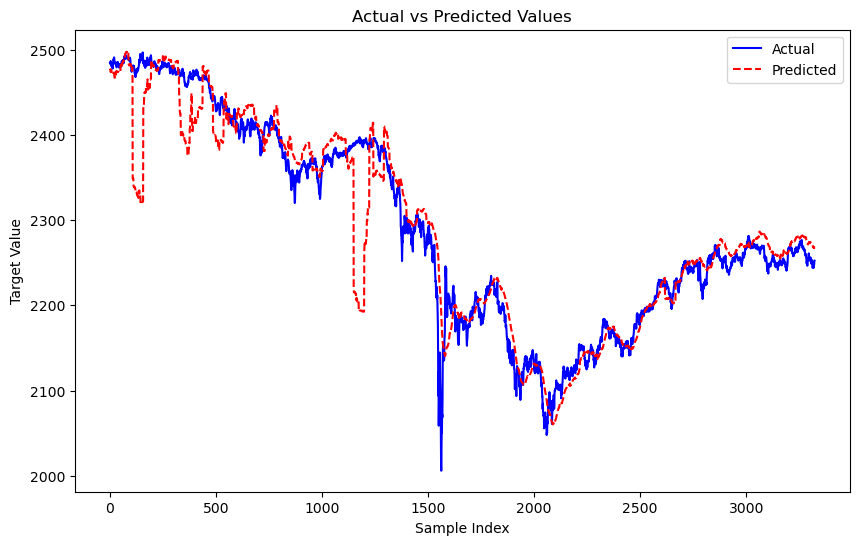

metrics for  lvl -  3 window -  50 c -  1 ofi -  False


2024-12-07 01:33:06.598840: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 01:33:06.826252: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1167.3819324841713
R² Score: 0.9182225349676716


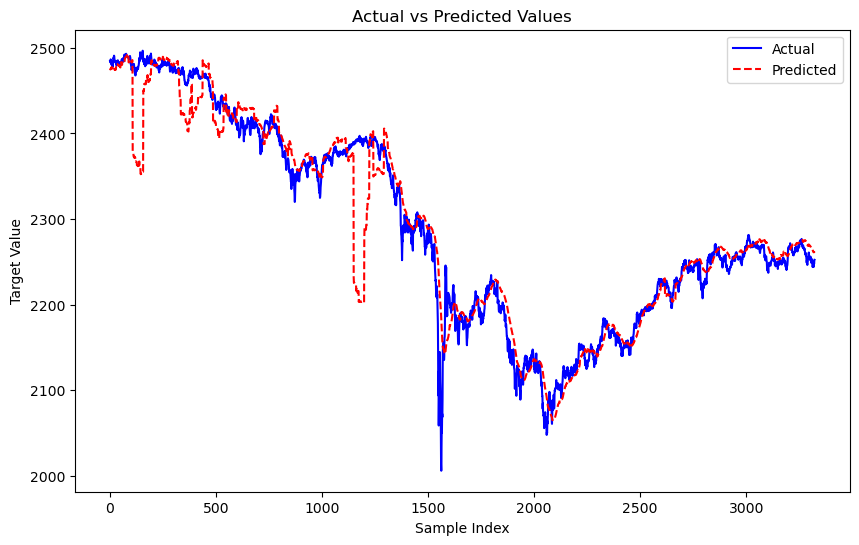

metrics for  lvl -  5 window -  50 c -  1 ofi -  True


2024-12-07 01:34:35.085971: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 01:34:35.378203: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 2551.713940869197
R² Score: 0.8212472784053775


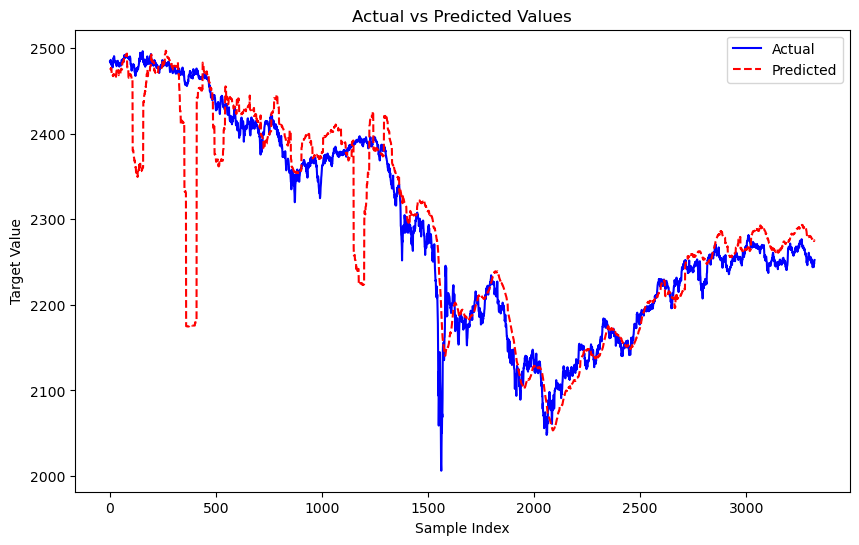

metrics for  lvl -  5 window -  50 c -  1 ofi -  False


2024-12-07 01:37:26.105196: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 01:37:26.359738: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 2153.780399960066
R² Score: 0.849123327641156


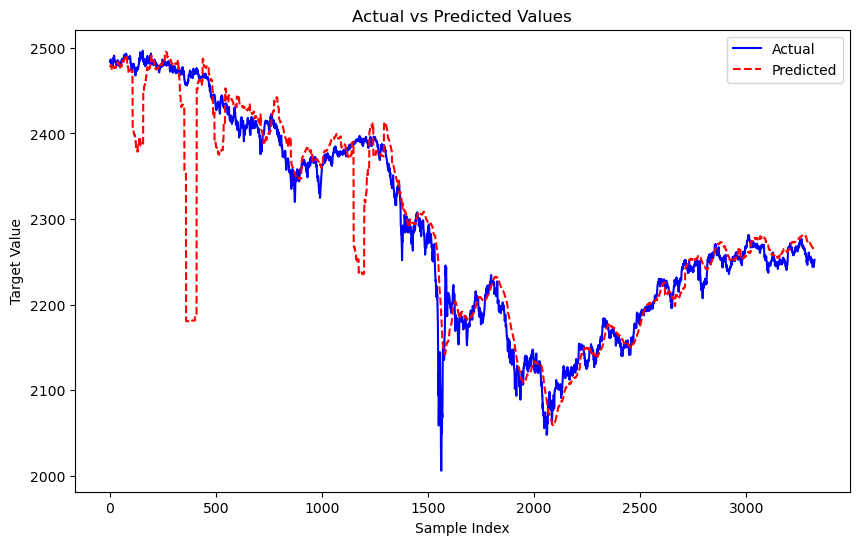

metrics for  lvl -  10 window -  50 c -  1 ofi -  True


2024-12-07 01:39:44.636865: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 01:39:45.059085: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 2369.6970962048385
R² Score: 0.8339979264457831


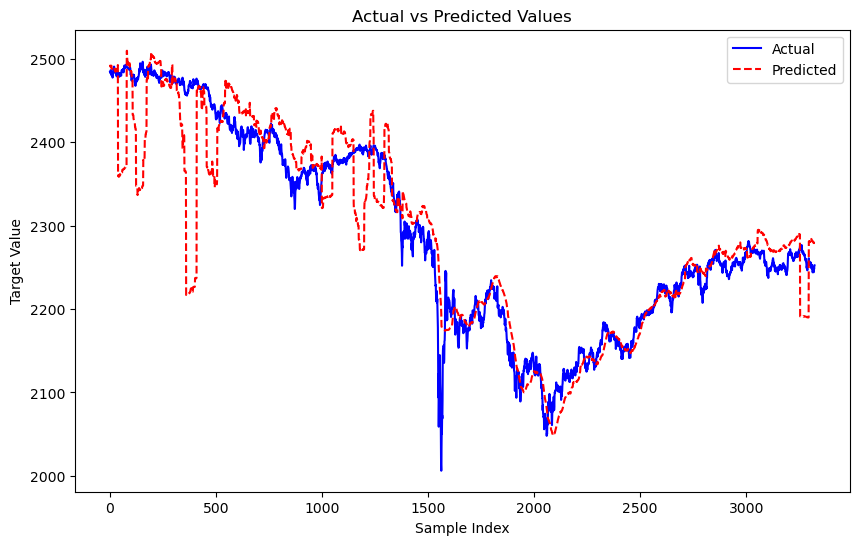

metrics for  lvl -  10 window -  50 c -  1 ofi -  False


2024-12-07 01:45:25.342984: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 01:45:25.676889: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1916.1263902832272
R² Score: 0.8657714715993063


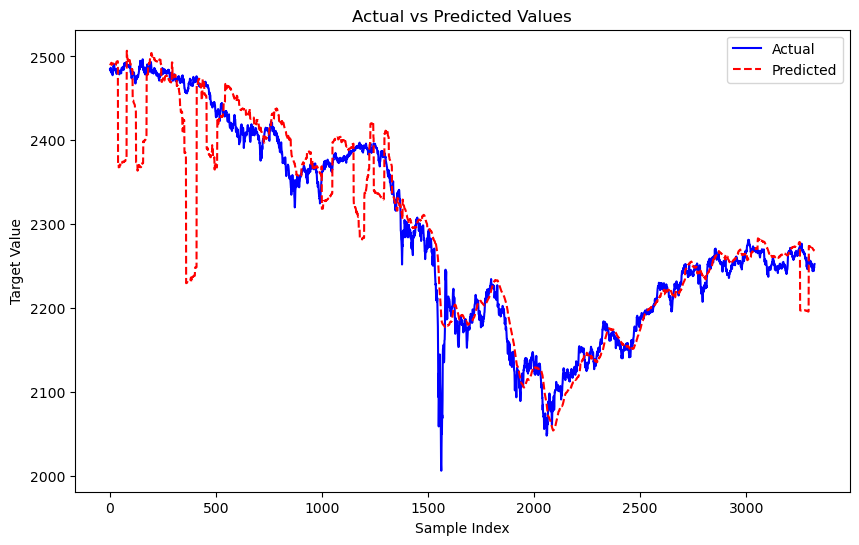

metrics for  lvl -  3 window -  100 c -  1 ofi -  True


2024-12-07 01:49:49.715840: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 01:49:50.019668: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1631.4215348271568
R² Score: 0.8844490349372885


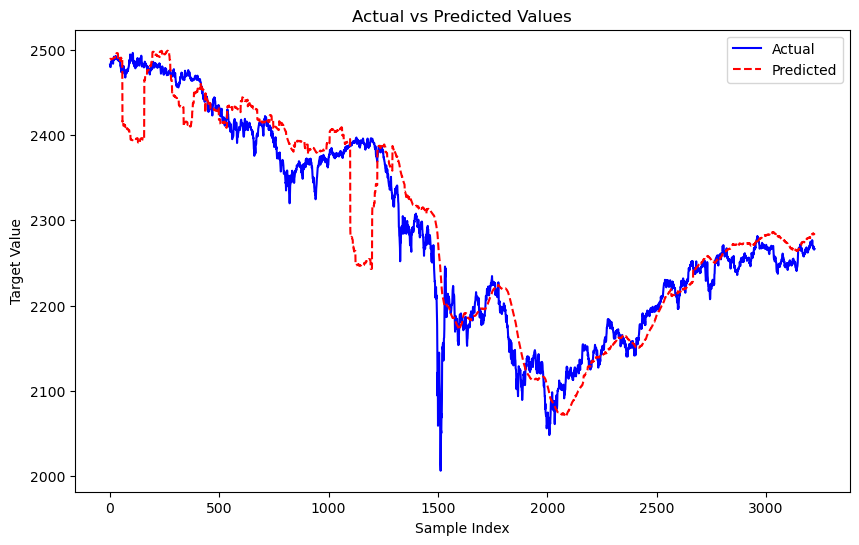

metrics for  lvl -  3 window -  100 c -  1 ofi -  False


2024-12-07 01:53:09.690502: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 01:53:09.951357: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1216.3588707271213
R² Score: 0.9138472562886699


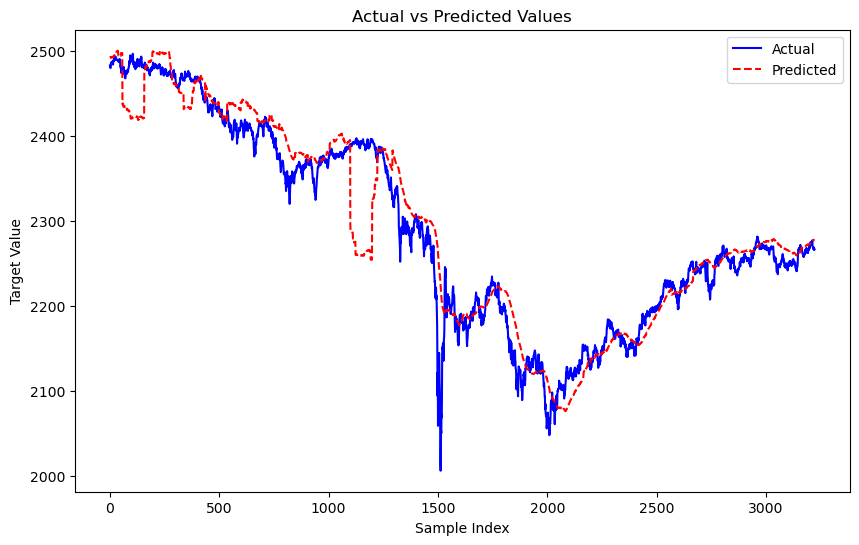

metrics for  lvl -  5 window -  100 c -  1 ofi -  True


2024-12-07 01:55:49.520390: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 01:55:49.912774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 3141.000189738884
R² Score: 0.777528005216052


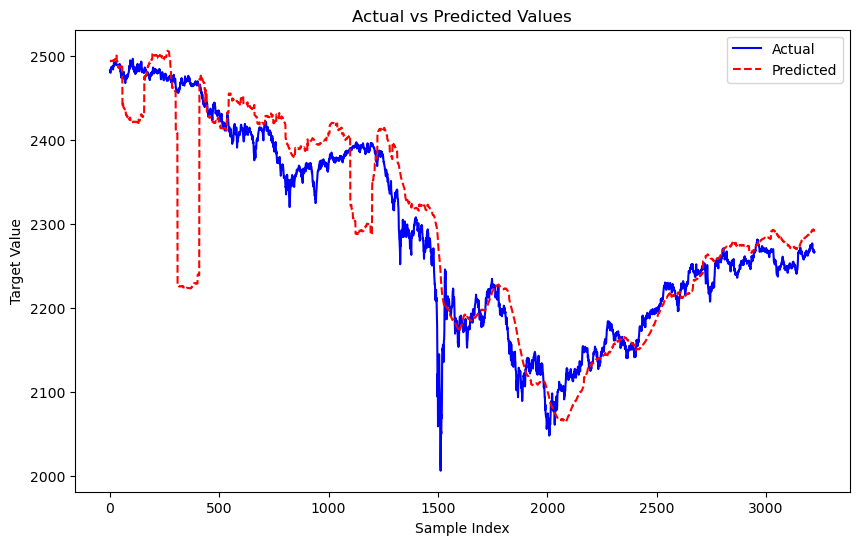

metrics for  lvl -  5 window -  100 c -  1 ofi -  False


2024-12-07 02:01:20.210483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 02:01:20.543922: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 2641.8948245340043
R² Score: 0.8128788360014939


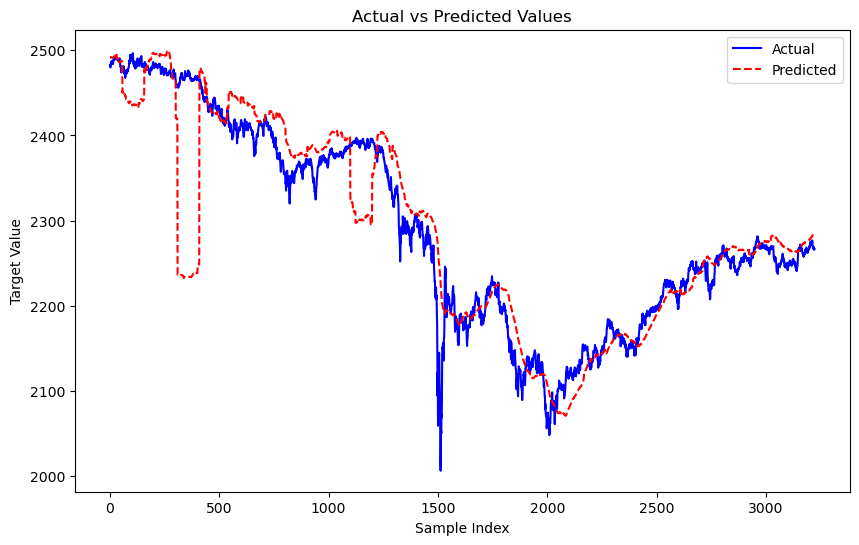

metrics for  lvl -  10 window -  100 c -  1 ofi -  True


2024-12-07 02:05:41.198111: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 02:05:41.982886: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 2126.118777809991
R² Score: 0.8494104243634829


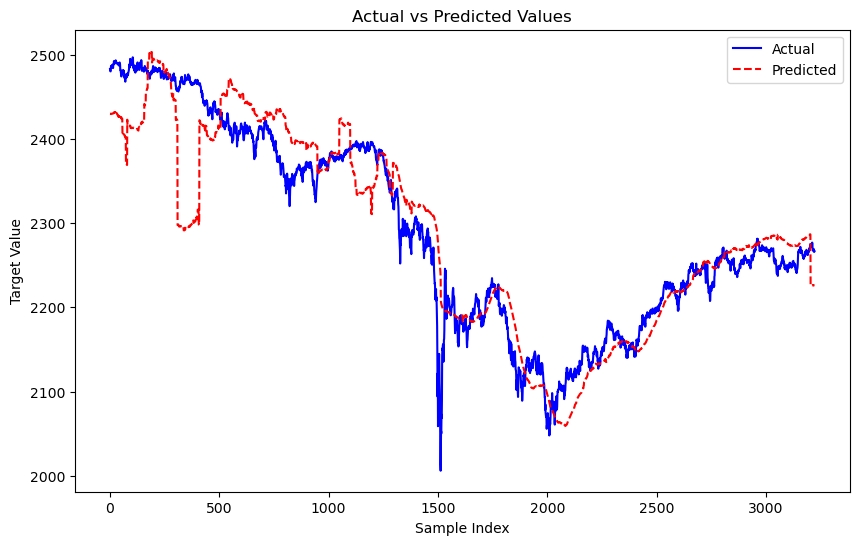

metrics for  lvl -  10 window -  100 c -  1 ofi -  False


2024-12-07 02:18:03.307785: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 02:18:03.948113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1691.5299781317083
R² Score: 0.8801916505127327


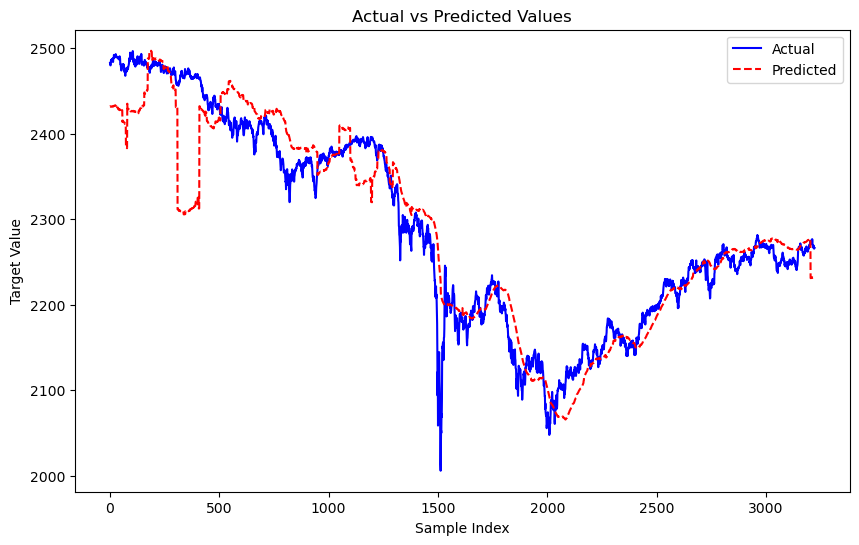

metrics for  lvl -  3 window -  25 c -  10 ofi -  True


2024-12-07 02:27:21.706491: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 02:27:21.906046: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 974.5355432802141
R² Score: 0.9320209846488563


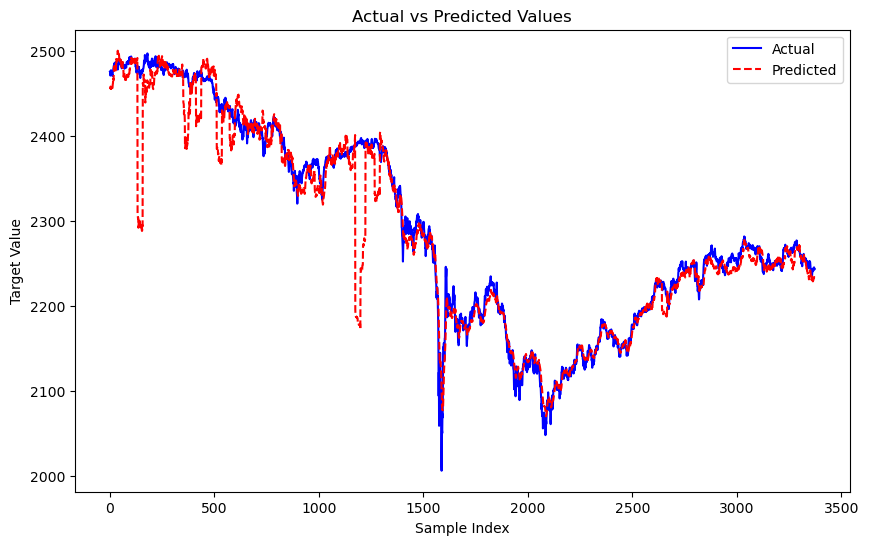

metrics for  lvl -  3 window -  25 c -  10 ofi -  False


2024-12-07 02:28:25.215168: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 02:28:25.406798: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 788.2653730882913
R² Score: 0.9450143155193917


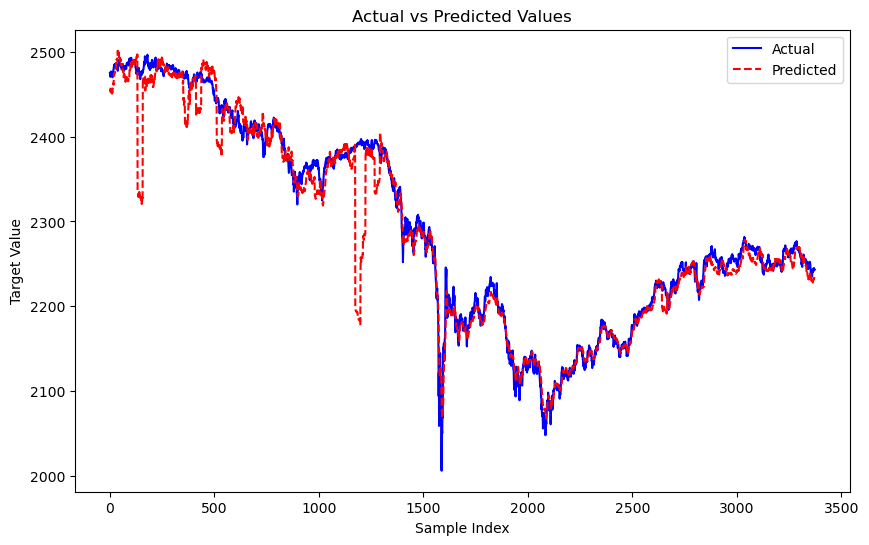

metrics for  lvl -  5 window -  25 c -  10 ofi -  True


2024-12-07 02:29:17.864644: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 02:29:18.096442: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1431.7156254437746
R² Score: 0.9001302526607491


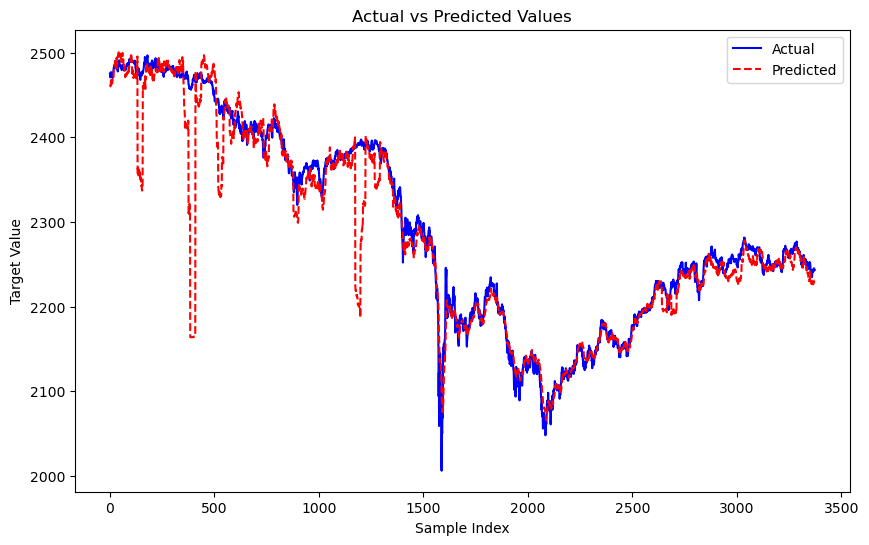

metrics for  lvl -  5 window -  25 c -  10 ofi -  False


2024-12-07 02:30:51.707197: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 02:30:51.942004: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1287.8189990431174
R² Score: 0.9101678044386378


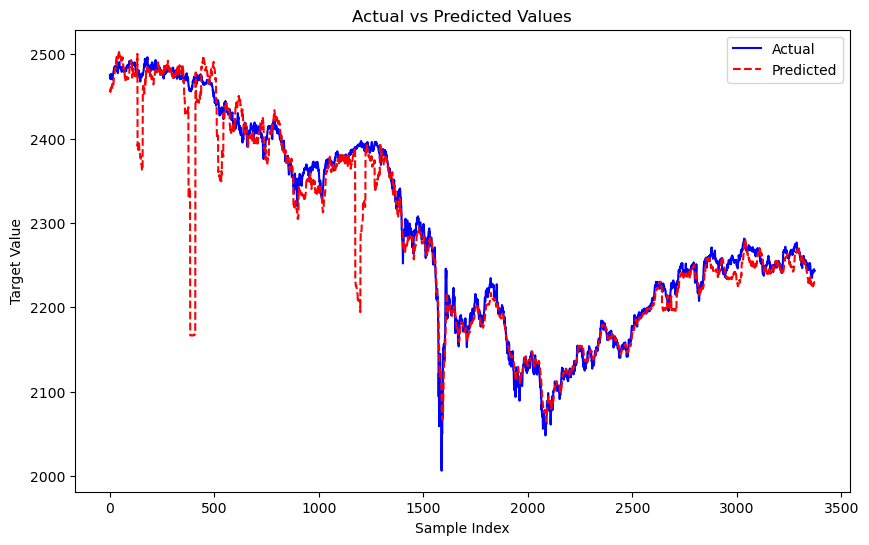

metrics for  lvl -  10 window -  25 c -  10 ofi -  True


2024-12-07 02:32:08.677425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 02:32:08.972051: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1683.267324835826
R² Score: 0.8825831893930303


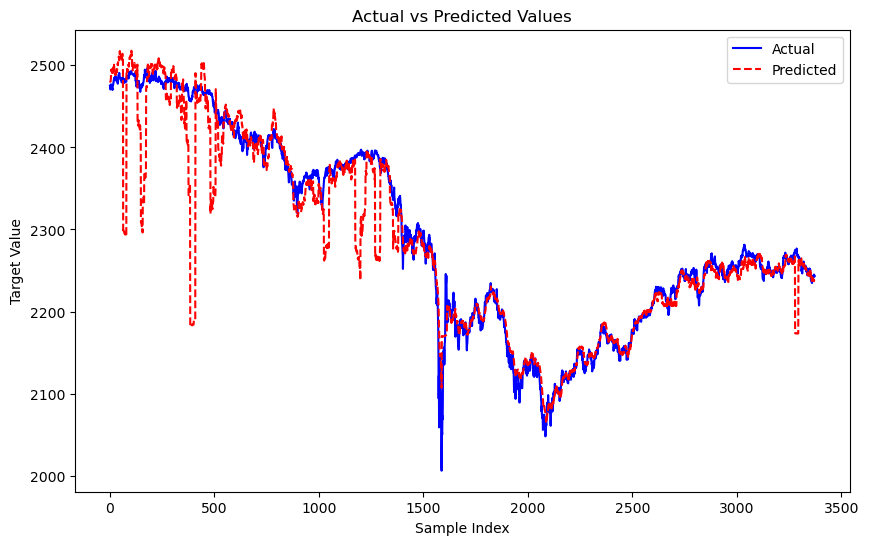

metrics for  lvl -  10 window -  25 c -  10 ofi -  False


2024-12-07 02:35:03.844361: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 02:35:04.105708: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1499.9421565793302
R² Score: 0.8953710907816367


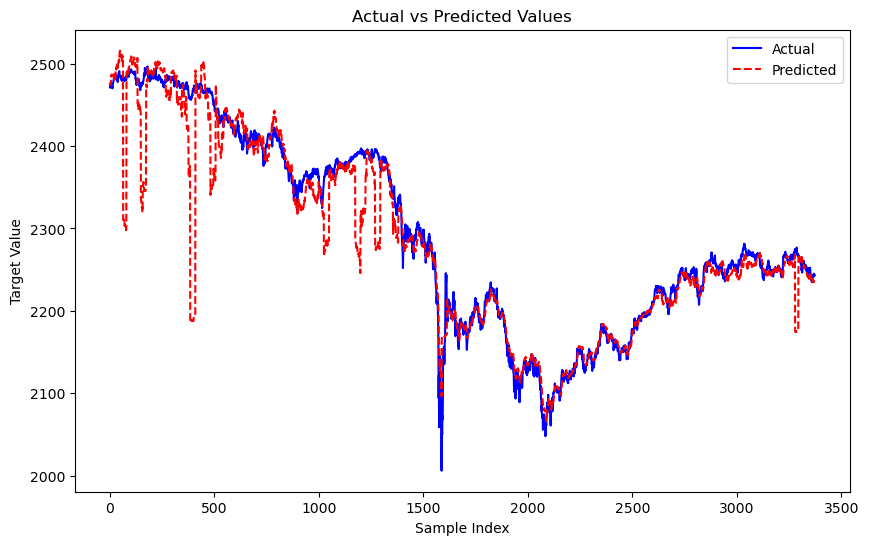

metrics for  lvl -  3 window -  50 c -  10 ofi -  True


2024-12-07 02:37:26.273399: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 02:37:26.500336: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 915.1868461019851
R² Score: 0.9358893107537736


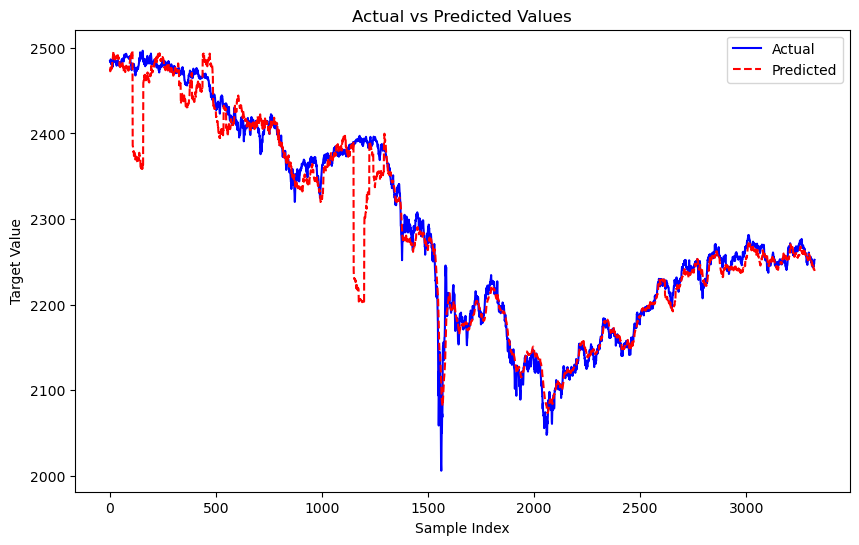

metrics for  lvl -  3 window -  50 c -  10 ofi -  False


2024-12-07 02:39:19.540624: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 02:39:19.779273: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 804.9962281165687
R² Score: 0.9436083863694271


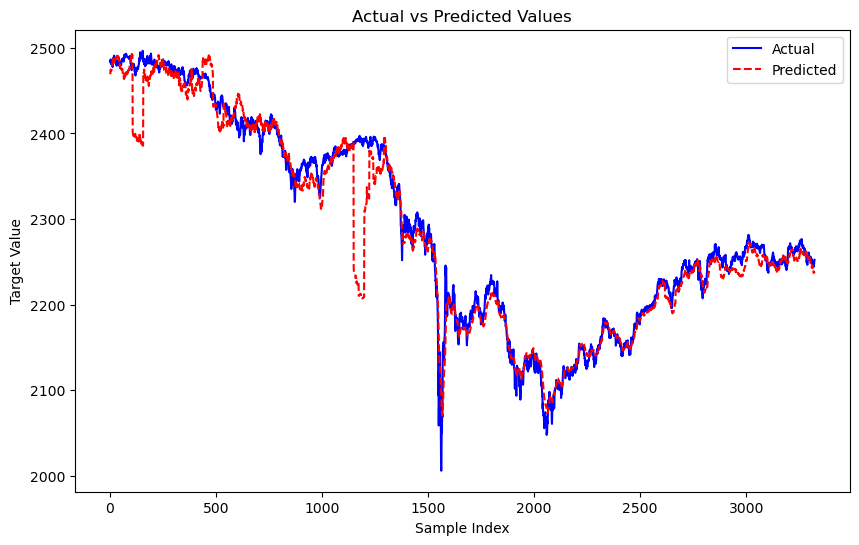

metrics for  lvl -  5 window -  50 c -  10 ofi -  True


2024-12-07 02:40:49.201781: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 02:40:49.487677: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1836.3011115679208
R² Score: 0.871363393794766


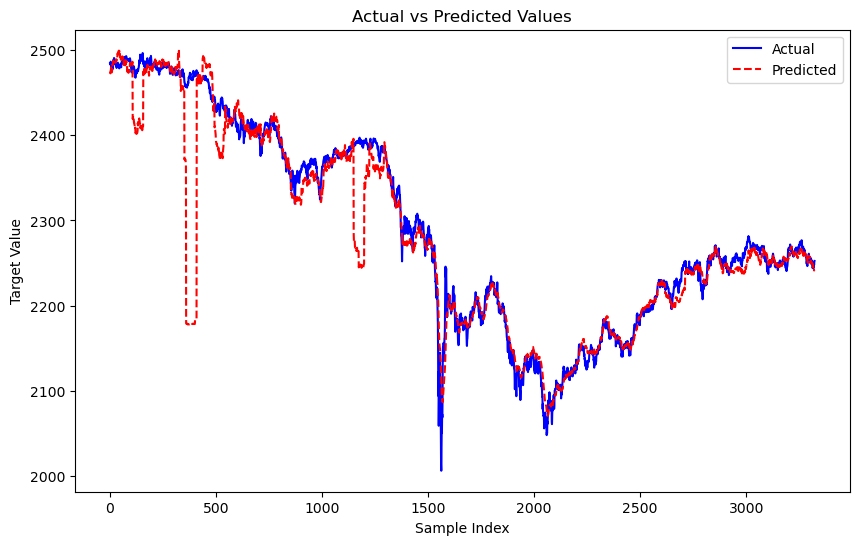

metrics for  lvl -  5 window -  50 c -  10 ofi -  False


2024-12-07 02:43:45.228331: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 02:43:45.487018: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1734.2623132575209
R² Score: 0.8785114179577002


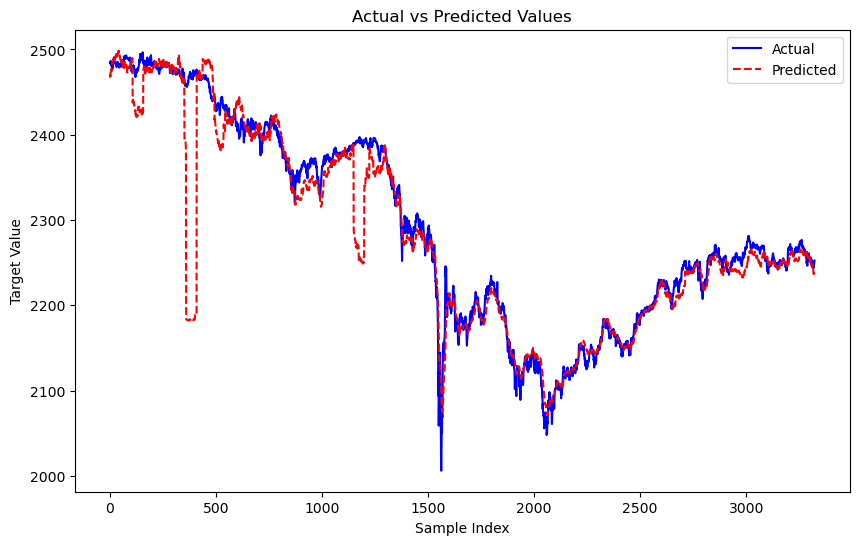

metrics for  lvl -  10 window -  50 c -  10 ofi -  True


2024-12-07 02:46:08.022378: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 02:46:08.428513: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1635.646407090995
R² Score: 0.8854196616042359


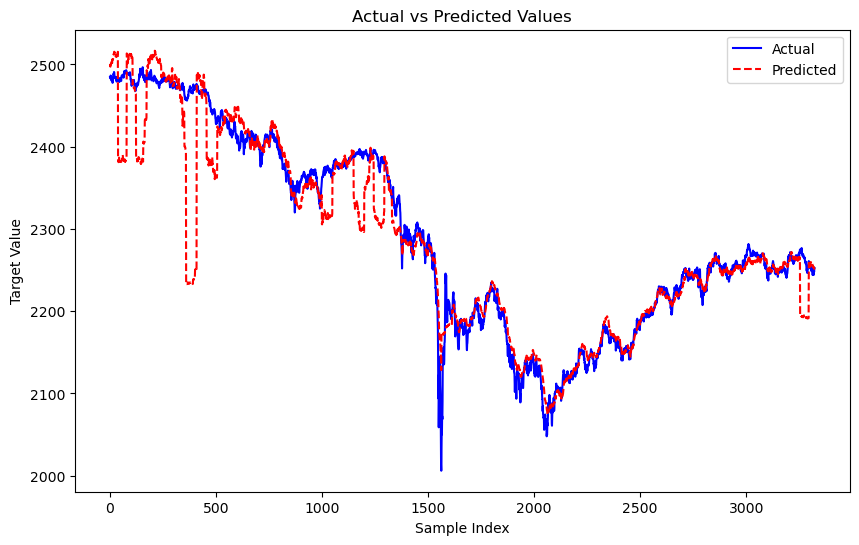

metrics for  lvl -  10 window -  50 c -  10 ofi -  False


2024-12-07 02:51:54.255972: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 02:51:54.607758: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1440.966998005917
R² Score: 0.8990573478883562


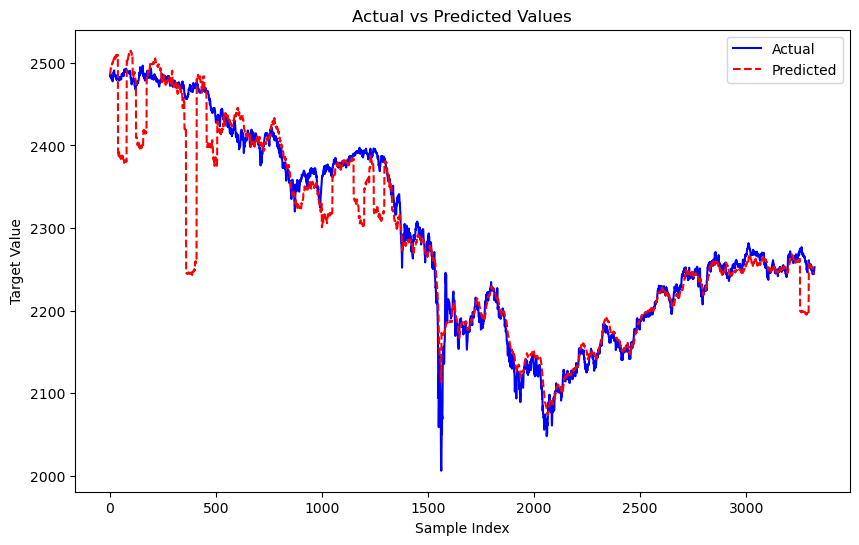

metrics for  lvl -  3 window -  100 c -  10 ofi -  True


2024-12-07 02:56:23.850063: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 02:56:24.157954: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 716.2290931214122
R² Score: 0.9492706445578837


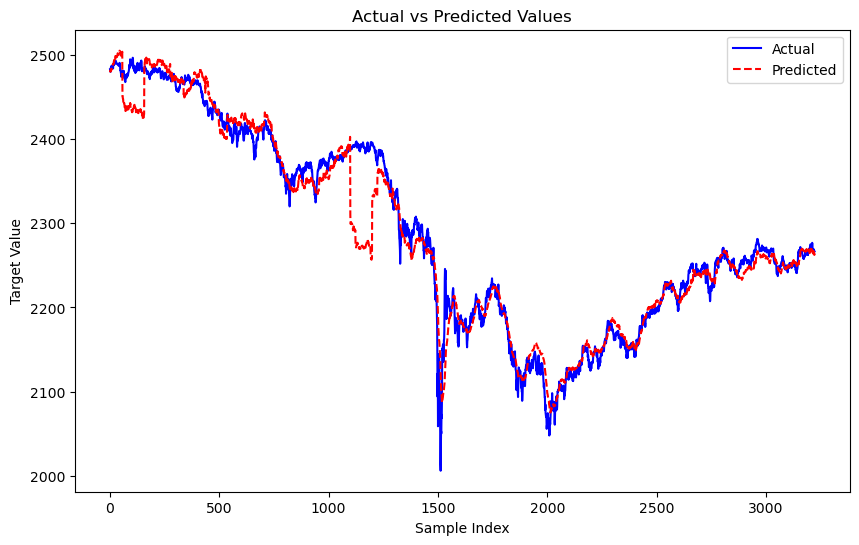

metrics for  lvl -  3 window -  100 c -  10 ofi -  False


2024-12-07 02:59:48.277541: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 02:59:48.642978: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 680.504863538592
R² Score: 0.9518009343182515


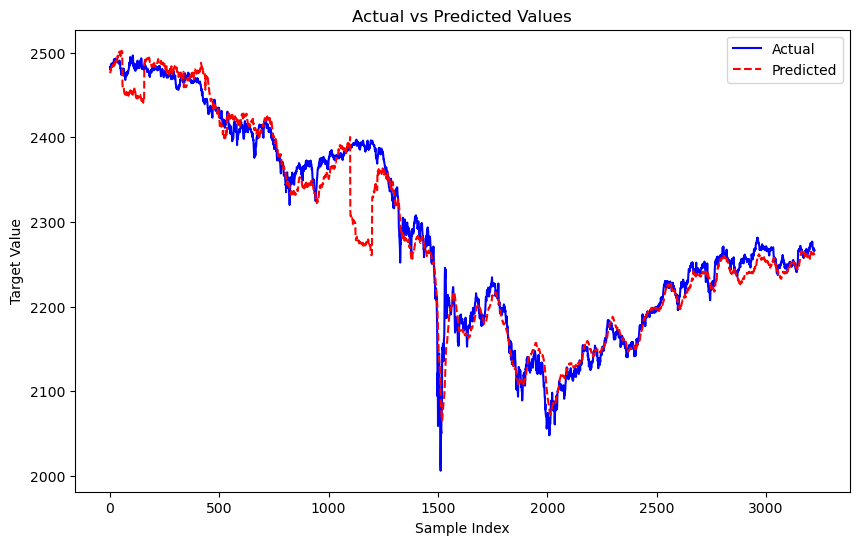

metrics for  lvl -  5 window -  100 c -  10 ofi -  True


2024-12-07 03:02:31.419893: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 03:02:31.806872: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 2109.9583861577435
R² Score: 0.8505550389289676


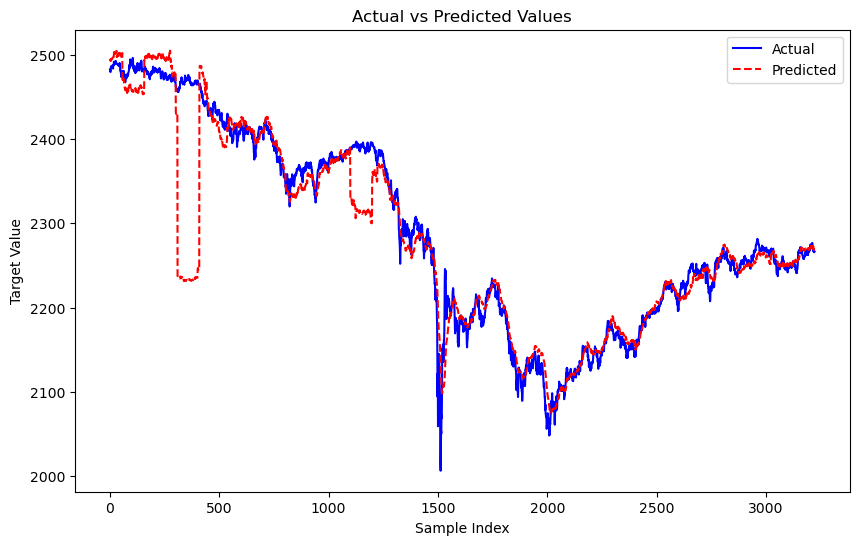

metrics for  lvl -  5 window -  100 c -  10 ofi -  False


2024-12-07 03:08:14.514888: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 03:08:14.863396: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1983.8605948883999
R² Score: 0.8594863428025509


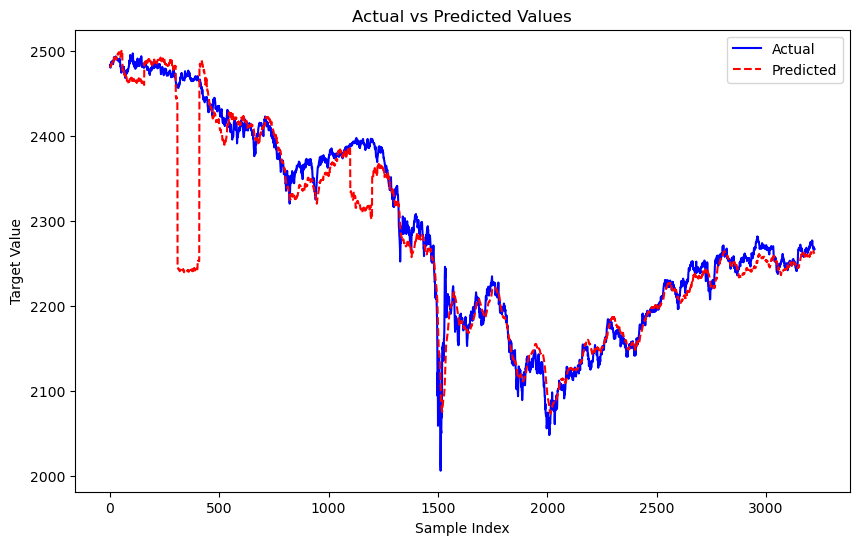

metrics for  lvl -  10 window -  100 c -  10 ofi -  True


2024-12-07 03:12:42.241896: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 03:12:43.018627: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 1125.1713662231043
R² Score: 0.9203059206633657


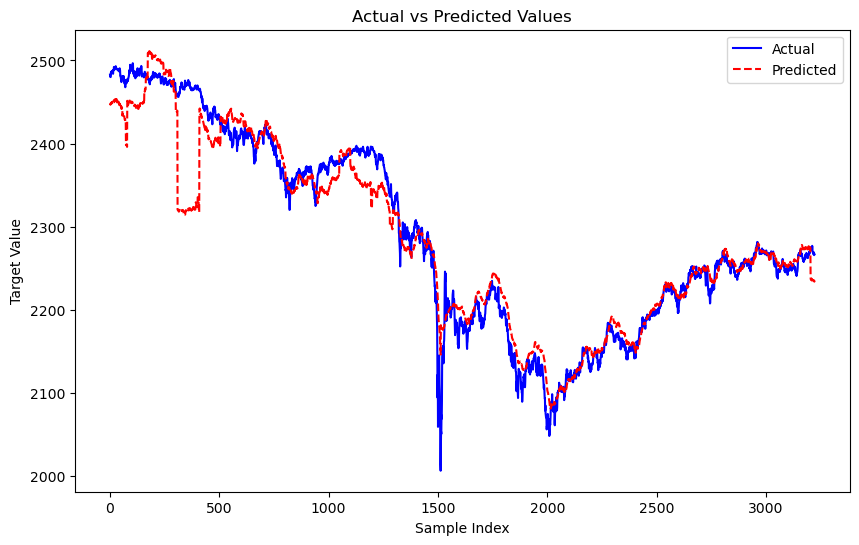

metrics for  lvl -  10 window -  100 c -  10 ofi -  False


2024-12-07 03:25:20.406215: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 03:25:20.952035: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 948.72365342448
R² Score: 0.9328034285494249


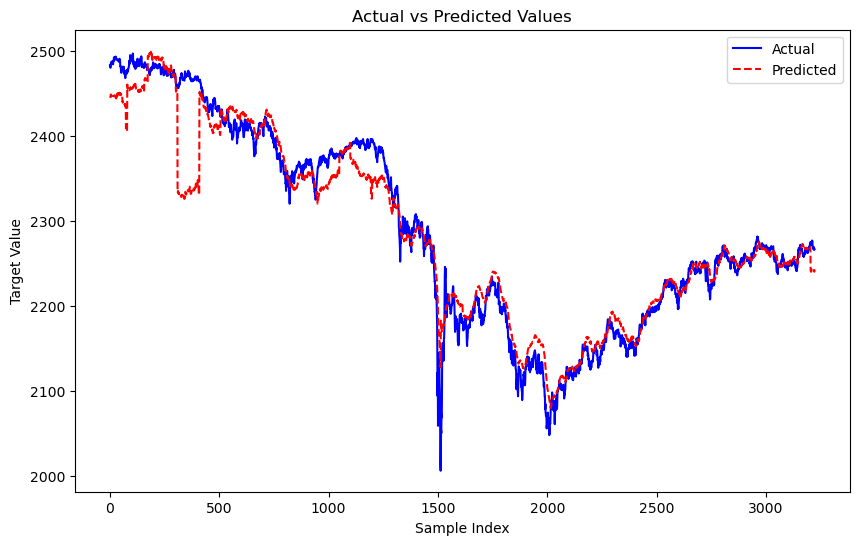

metrics for  lvl -  3 window -  25 c -  0.1 ofi -  True


2024-12-07 03:34:42.346757: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 03:34:42.553379: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 3246.713797237887
R² Score: 0.7735245178228017


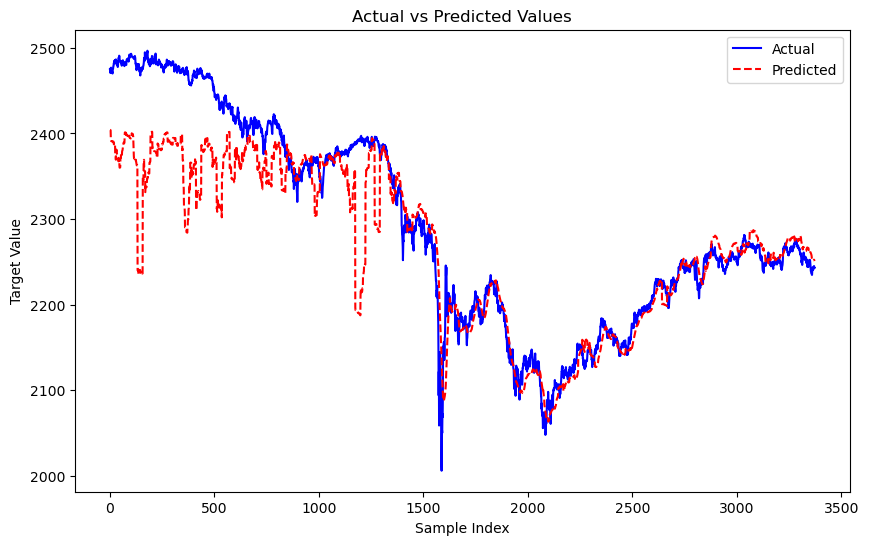

metrics for  lvl -  3 window -  25 c -  0.1 ofi -  False


2024-12-07 03:35:44.610669: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 03:35:44.817549: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 2662.0079692117038
R² Score: 0.8143108459699591


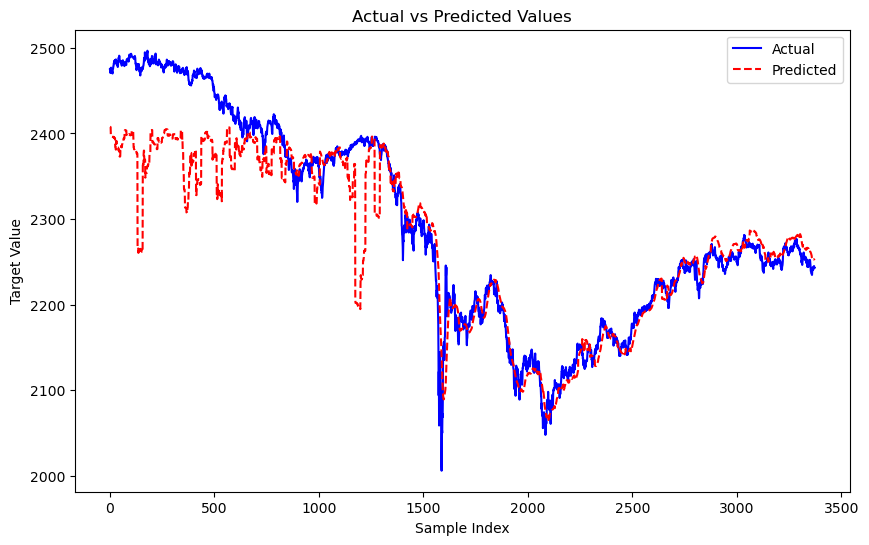

metrics for  lvl -  5 window -  25 c -  0.1 ofi -  True


2024-12-07 03:36:35.857242: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 03:36:36.088752: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 3488.789799911028
R² Score: 0.7566384345851694


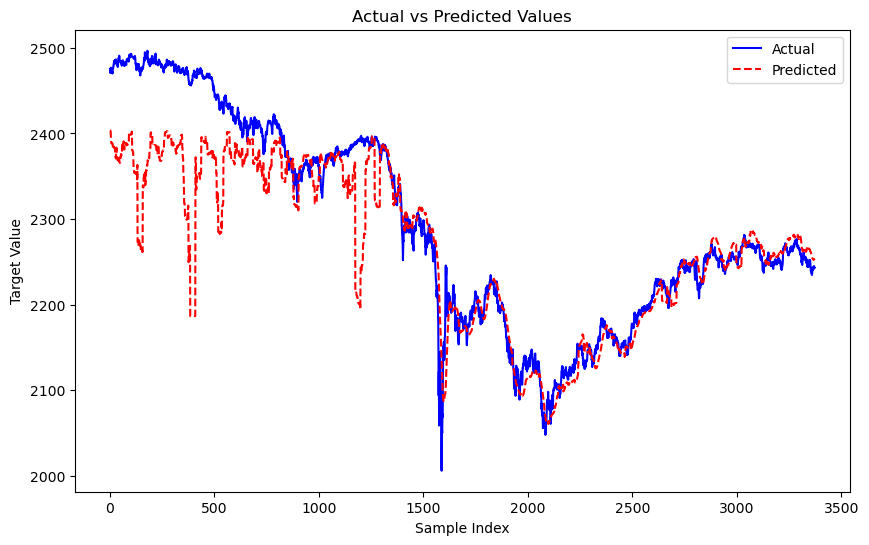

metrics for  lvl -  5 window -  25 c -  0.1 ofi -  False


2024-12-07 03:38:06.543961: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 03:38:06.762800: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 2948.364778801621
R² Score: 0.7943359419356788


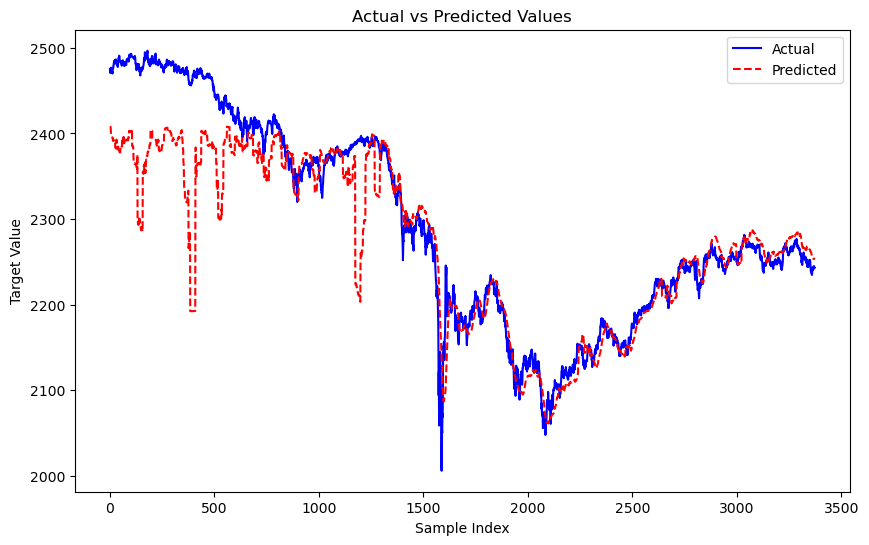

metrics for  lvl -  10 window -  25 c -  0.1 ofi -  True


2024-12-07 03:39:20.999289: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 03:39:21.286012: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 3629.3423429055583
R² Score: 0.7468341503353539


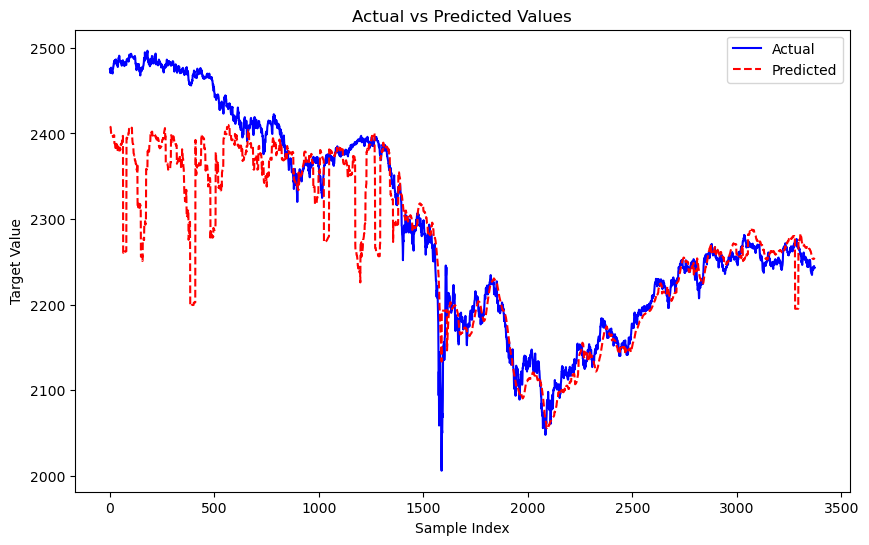

metrics for  lvl -  10 window -  25 c -  0.1 ofi -  False


2024-12-07 03:42:12.322853: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 03:42:12.593606: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 3119.2851131986845
R² Score: 0.7824133434056222


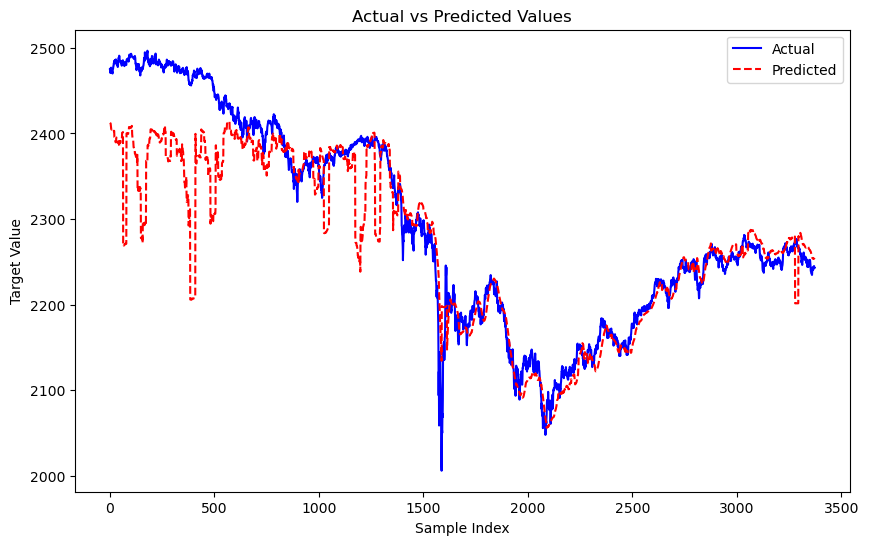

metrics for  lvl -  3 window -  50 c -  0.1 ofi -  True


2024-12-07 03:44:31.387152: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 03:44:31.624943: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 3495.0295379673566
R² Score: 0.7551661132703408


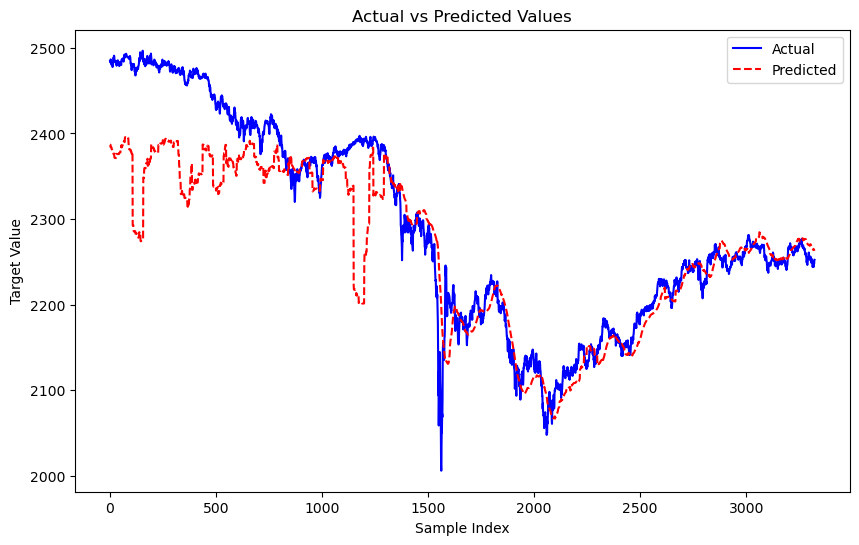

metrics for  lvl -  3 window -  50 c -  0.1 ofi -  False


2024-12-07 03:46:21.374357: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 03:46:21.620248: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 2874.44508455282
R² Score: 0.7986393091683782


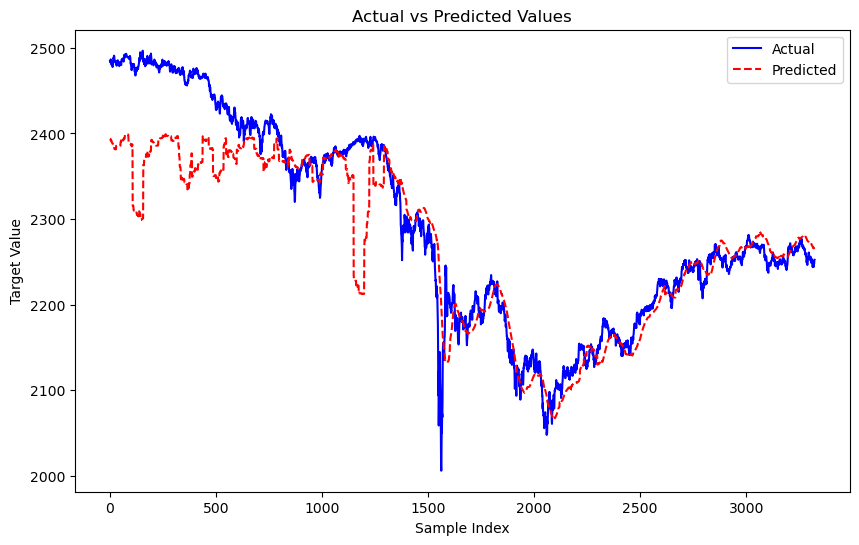

metrics for  lvl -  5 window -  50 c -  0.1 ofi -  True


2024-12-07 03:47:48.745135: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 03:47:49.030079: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 3942.568367563328
R² Score: 0.7238151132509962


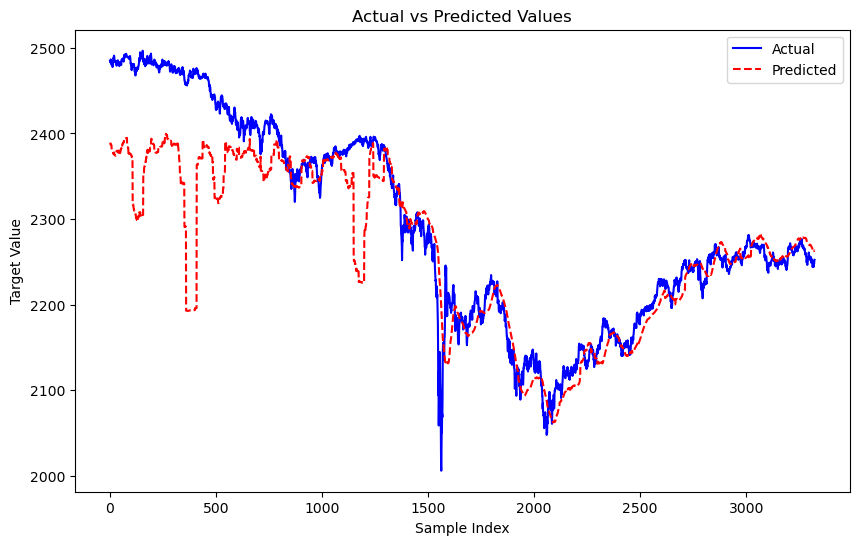

metrics for  lvl -  5 window -  50 c -  0.1 ofi -  False


2024-12-07 03:50:38.615577: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 03:50:38.873157: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 3410.9137724660964
R² Score: 0.7610585927413129


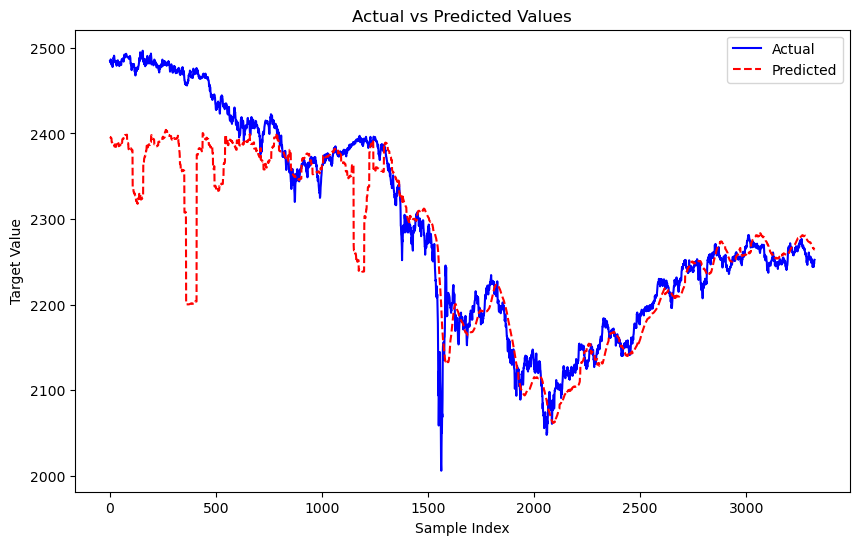

metrics for  lvl -  10 window -  50 c -  0.1 ofi -  True


2024-12-07 03:52:57.344044: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 03:52:57.755075: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 3927.1026149012614
R² Score: 0.7248985204995815


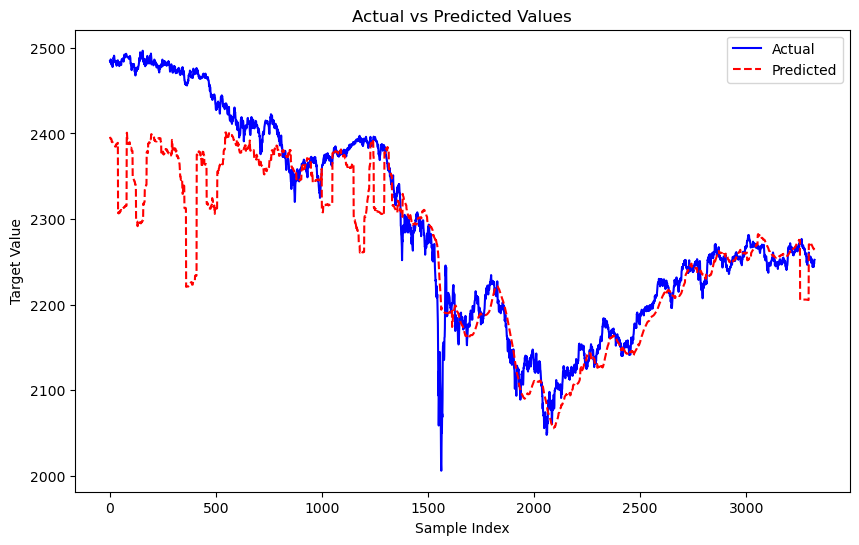

metrics for  lvl -  10 window -  50 c -  0.1 ofi -  False


2024-12-07 03:58:34.021365: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 03:58:34.370282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 3361.3435055753744
R² Score: 0.7645310901772403


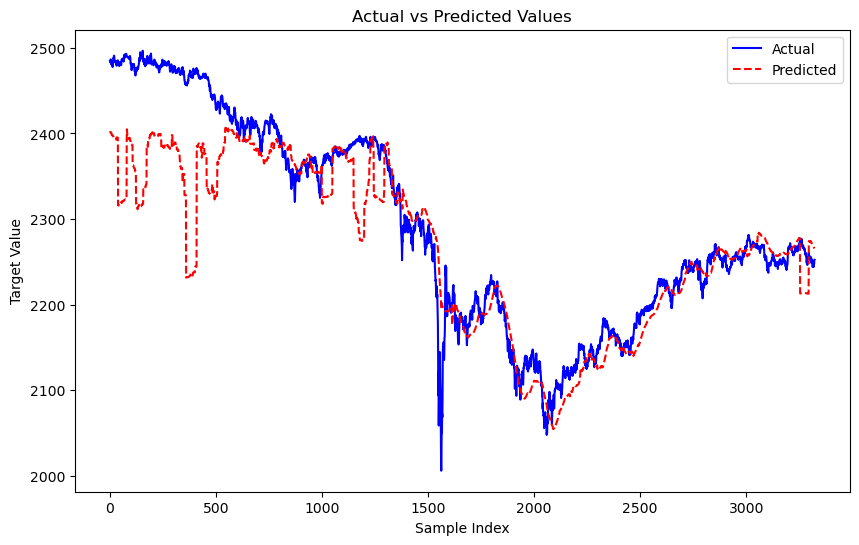

metrics for  lvl -  3 window -  100 c -  0.1 ofi -  True


2024-12-07 04:02:58.992907: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 04:02:59.453270: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 3554.8291399455643
R² Score: 0.7482171658367391


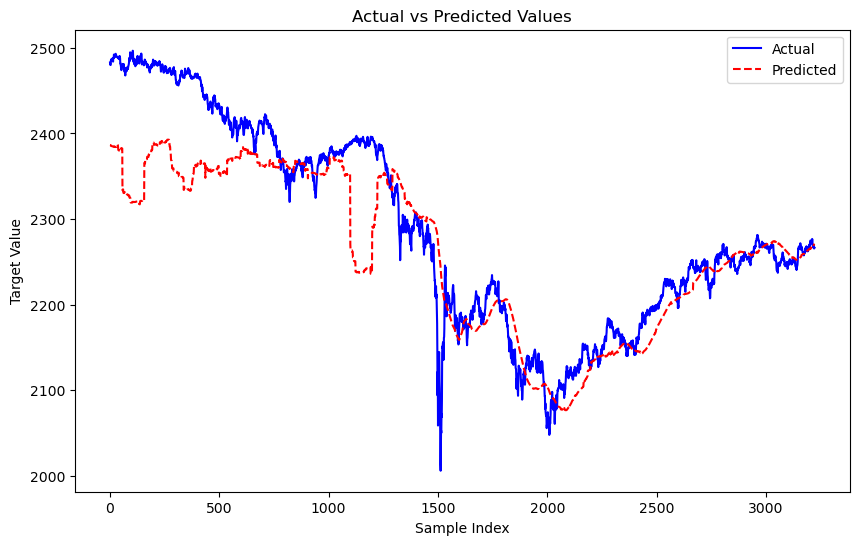

metrics for  lvl -  3 window -  100 c -  0.1 ofi -  False


2024-12-07 04:06:20.281047: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 04:06:20.552610: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 2946.337761245051
R² Score: 0.7913156321375616


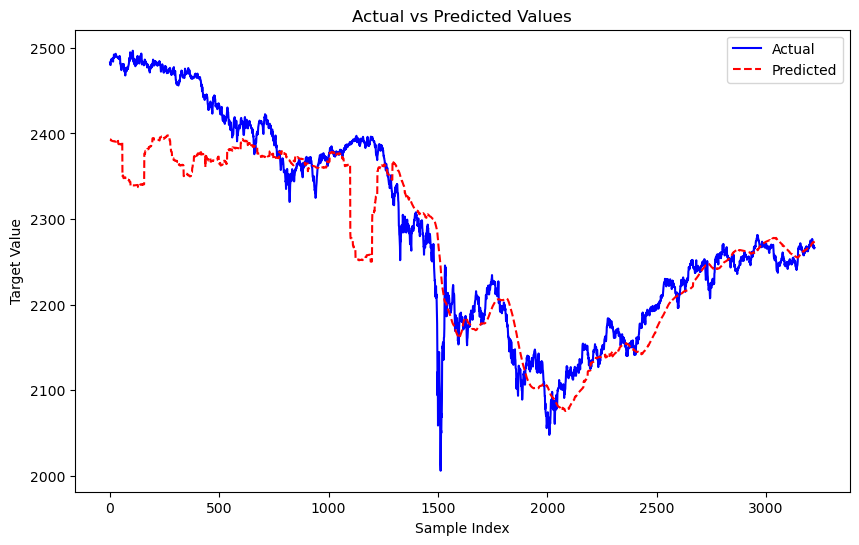

metrics for  lvl -  5 window -  100 c -  0.1 ofi -  True


2024-12-07 04:09:00.650013: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 04:09:01.052817: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 4474.7227417016065
R² Score: 0.6830625806061441


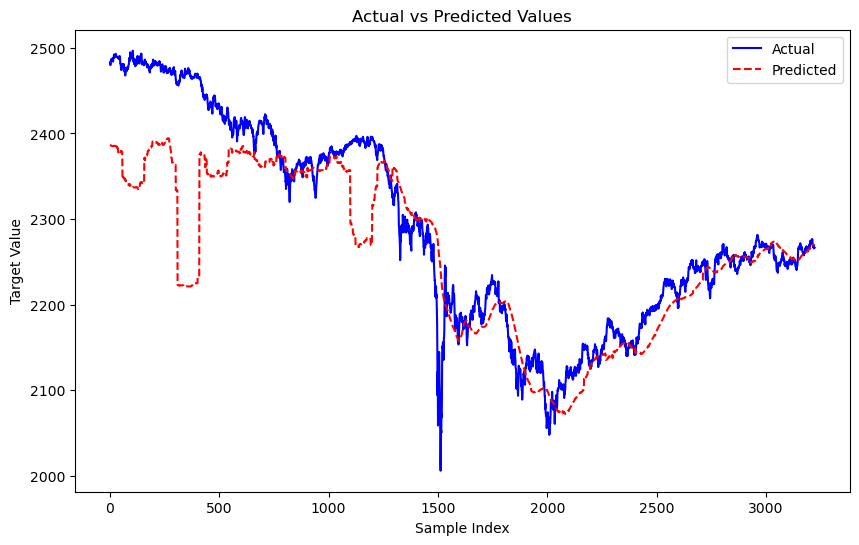

metrics for  lvl -  5 window -  100 c -  0.1 ofi -  False


2024-12-07 04:14:32.933334: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 04:14:33.270398: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 3868.8967849123424
R² Score: 0.725972259357232


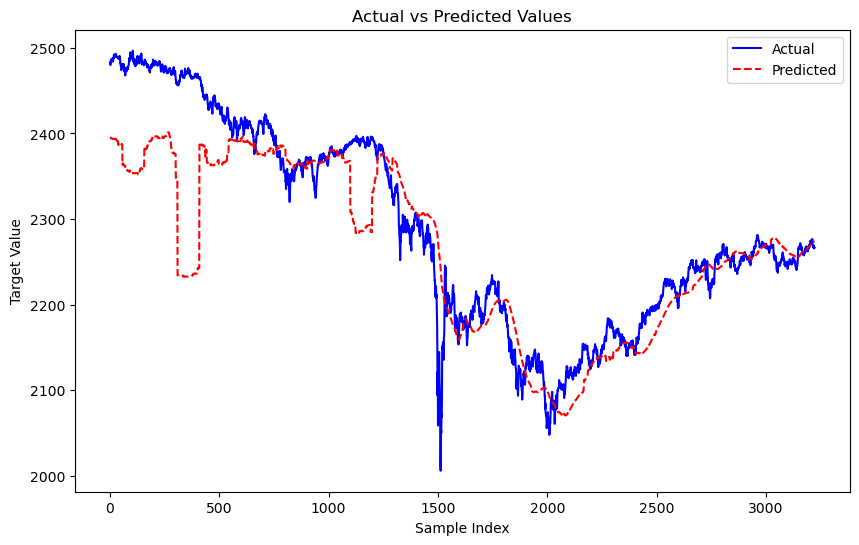

metrics for  lvl -  10 window -  100 c -  0.1 ofi -  True


2024-12-07 04:18:54.708024: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 04:18:55.396282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 3996.1319260395067
R² Score: 0.7169603988213272


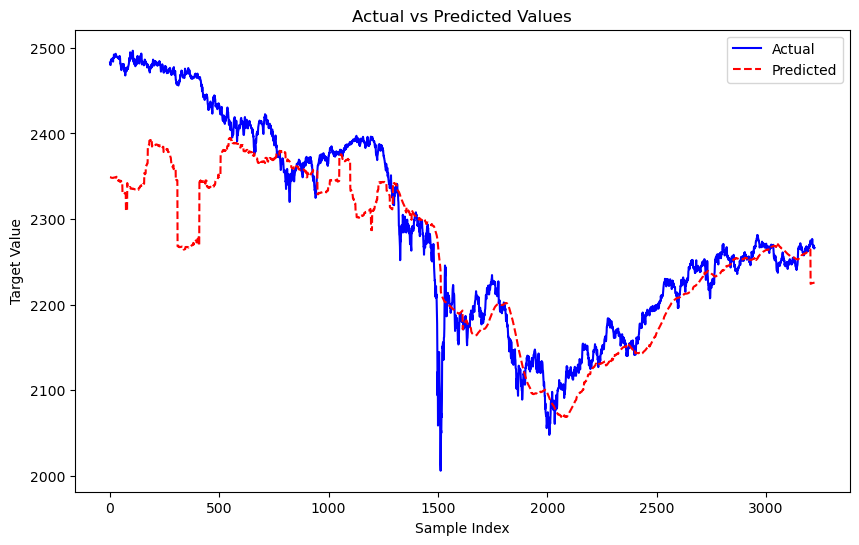

metrics for  lvl -  10 window -  100 c -  0.1 ofi -  False


2024-12-07 04:31:20.160920: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 04:31:20.717215: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 3385.4401286986104
R² Score: 0.760214717237627


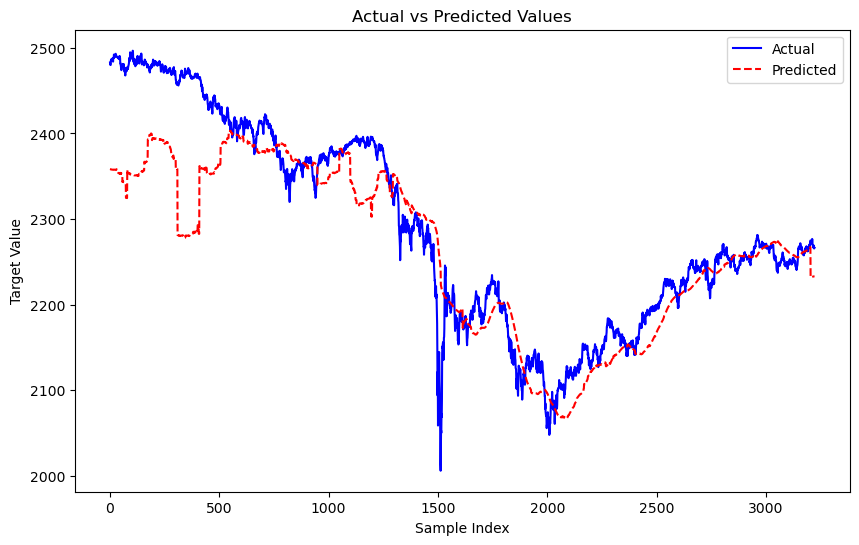

metrics for  lvl -  3 window -  25 c -  0.05 ofi -  True


2024-12-07 04:40:39.621779: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 04:40:39.829422: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 8152.609630437204
R² Score: 0.43131230149497146


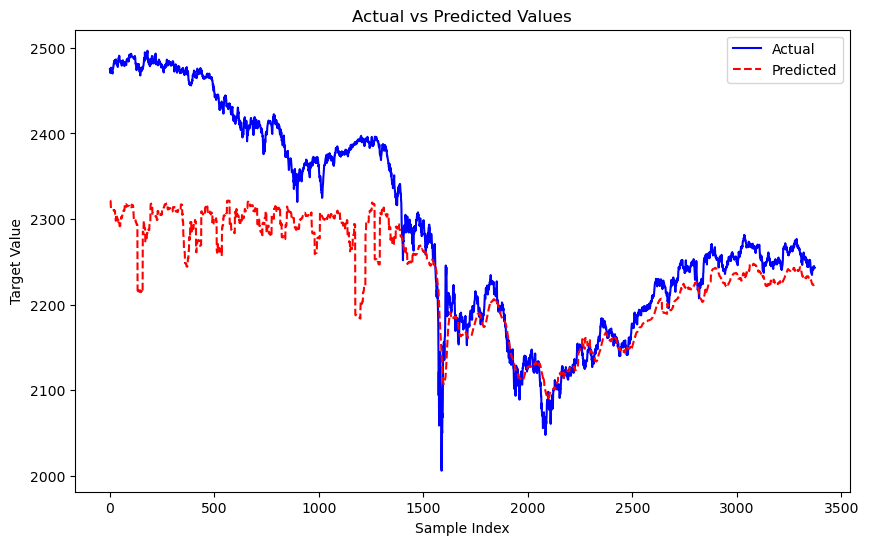

metrics for  lvl -  3 window -  25 c -  0.05 ofi -  False


2024-12-07 04:41:41.228733: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 04:41:41.443420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 6074.966312509666
R² Score: 0.5762389262625062


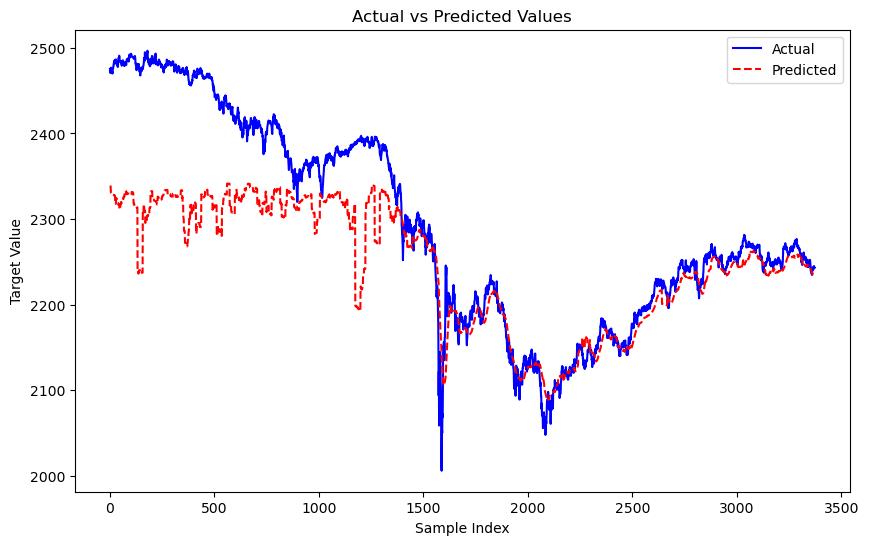

metrics for  lvl -  5 window -  25 c -  0.05 ofi -  True


2024-12-07 04:42:32.464829: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 04:42:32.688536: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 8919.03027749584
R² Score: 0.377850402346105


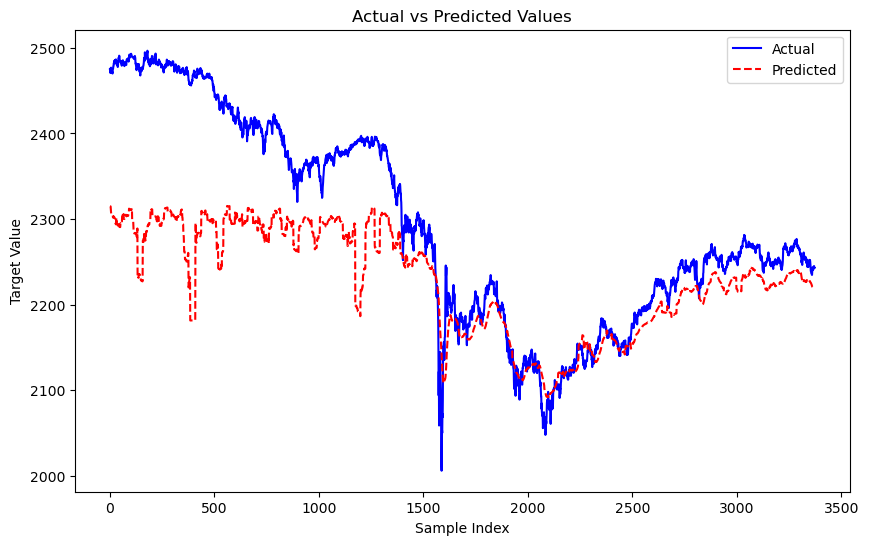

metrics for  lvl -  5 window -  25 c -  0.05 ofi -  False


2024-12-07 05:14:43.176740: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 05:14:43.544533: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 6655.874718066737
R² Score: 0.5357174884439804


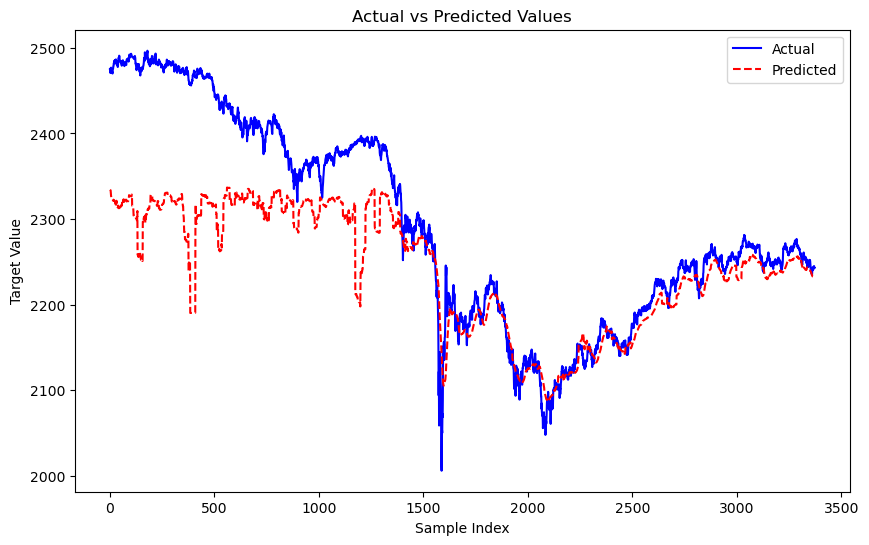

metrics for  lvl -  10 window -  25 c -  0.05 ofi -  True


2024-12-07 05:32:25.770904: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 9024.469693911384
R² Score: 0.37049544463671047


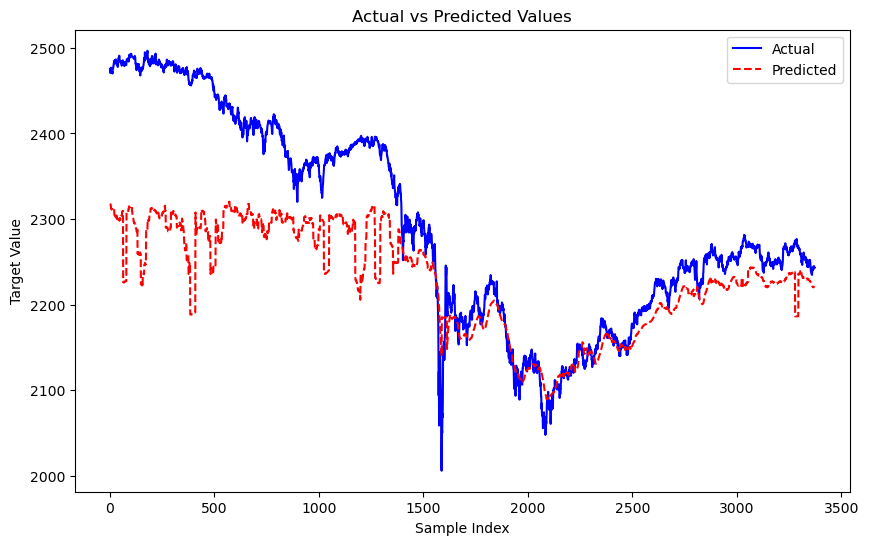

metrics for  lvl -  10 window -  25 c -  0.05 ofi -  False


2024-12-07 06:29:10.845736: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 06:29:11.114157: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 6773.440177307934
R² Score: 0.5275166750271385


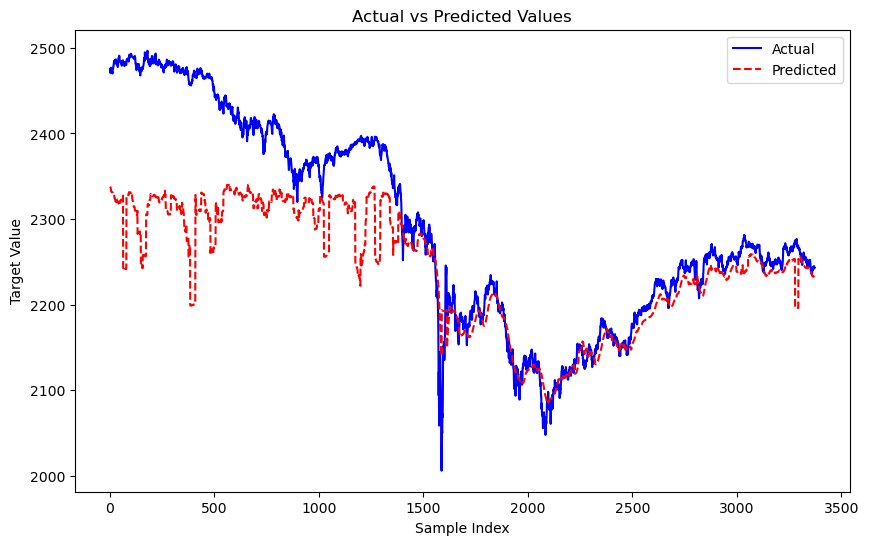

metrics for  lvl -  3 window -  50 c -  0.05 ofi -  True


2024-12-07 06:49:50.712991: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 06:49:51.400955: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 9185.082979749
R² Score: 0.35656636333486924


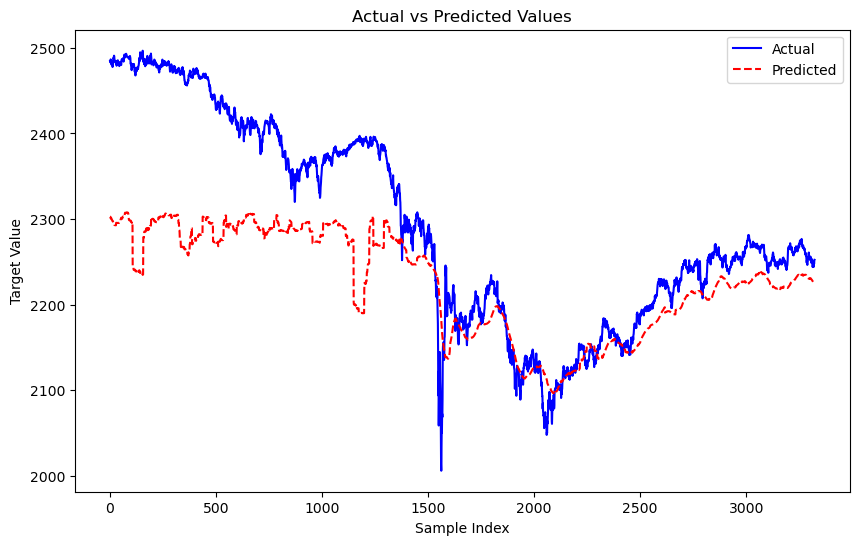

metrics for  lvl -  3 window -  50 c -  0.05 ofi -  False


2024-12-07 07:44:22.382629: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 07:44:22.895282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 6847.7461000652875
R² Score: 0.5203015382834486


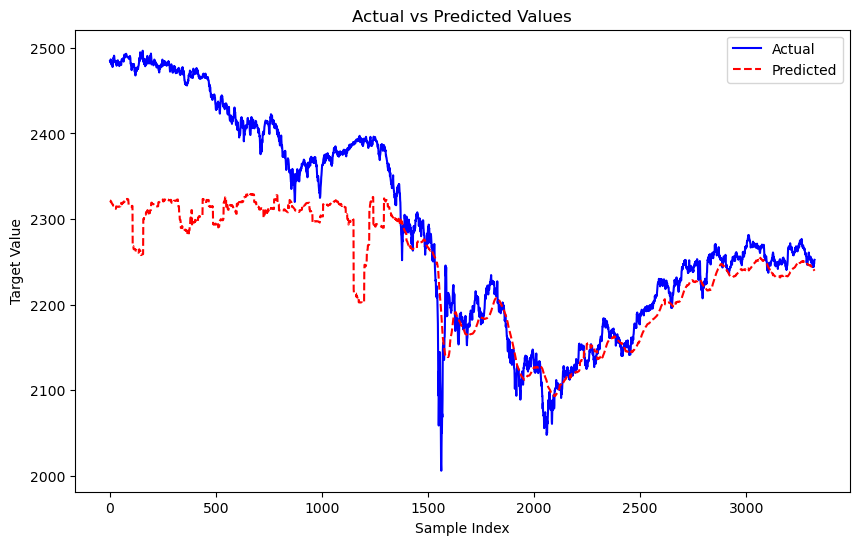

metrics for  lvl -  5 window -  50 c -  0.05 ofi -  True


2024-12-07 08:11:26.098480: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 08:11:26.561634: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 9924.19345140829
R² Score: 0.30479018017729353


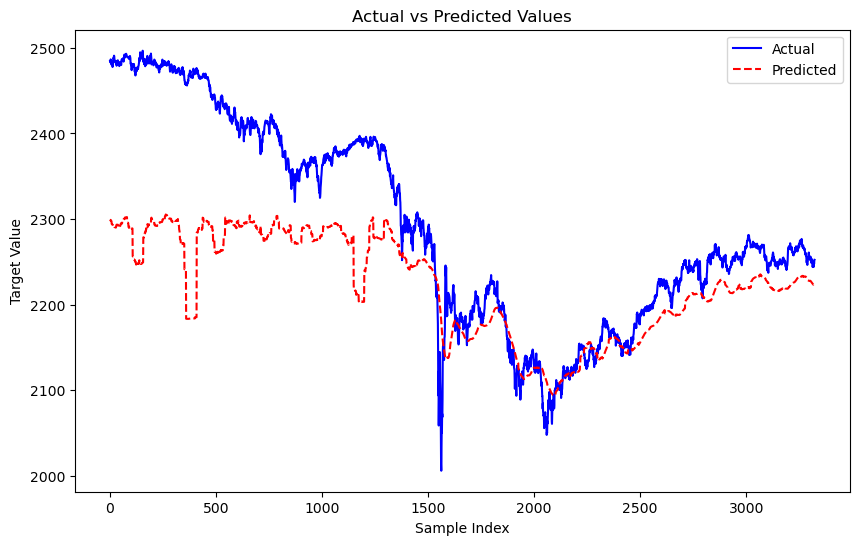

metrics for  lvl -  5 window -  50 c -  0.05 ofi -  False


2024-12-07 08:14:51.849976: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 08:14:52.147598: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 7512.82305540619
R² Score: 0.47371155265341525


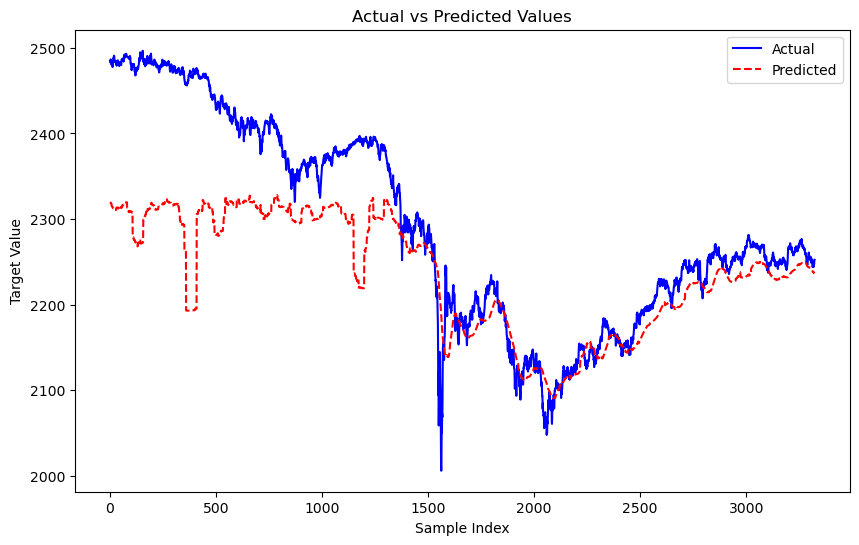

metrics for  lvl -  10 window -  50 c -  0.05 ofi -  True


2024-12-07 08:35:35.660258: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 08:35:36.058703: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 9894.433666117911
R² Score: 0.3068749133166653


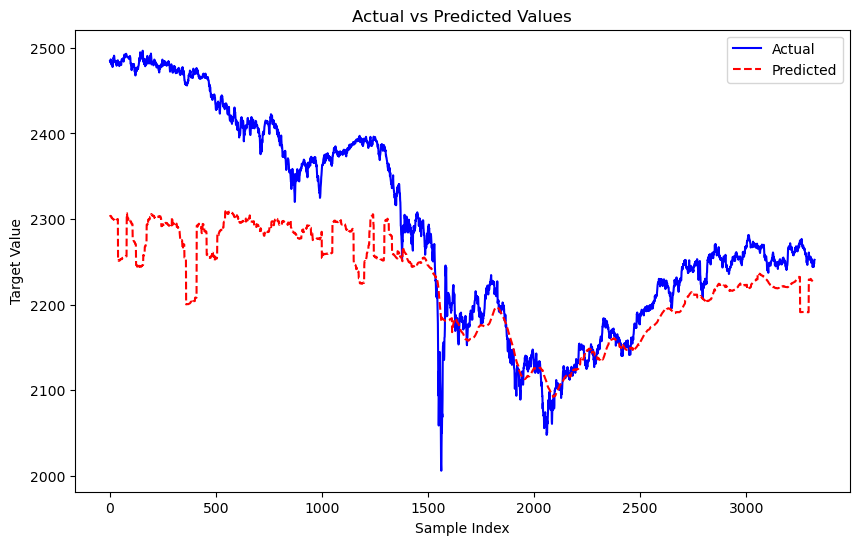

metrics for  lvl -  10 window -  50 c -  0.05 ofi -  False


2024-12-07 08:53:37.929340: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 08:53:38.288213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 7491.579981941124
R² Score: 0.47519967290706


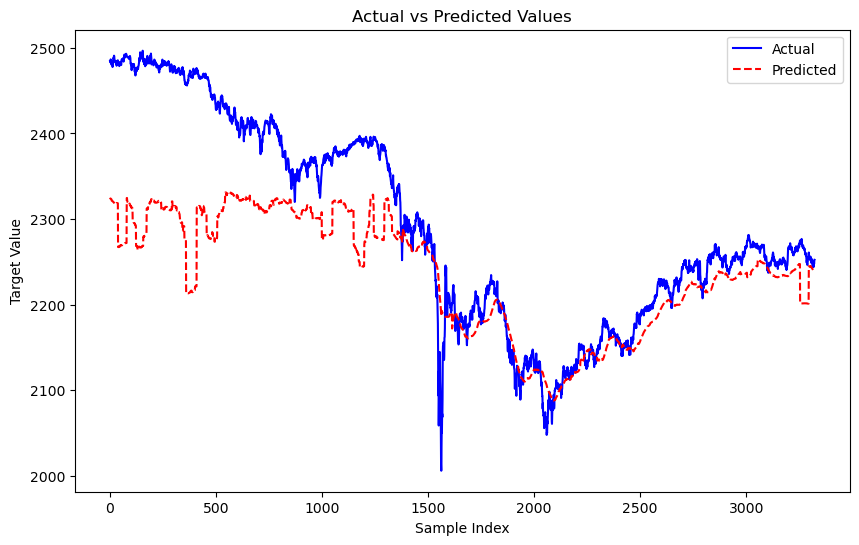

metrics for  lvl -  3 window -  100 c -  0.05 ofi -  True


2024-12-07 09:49:58.435698: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 09:49:59.058845: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 9866.908054032809
R² Score: 0.3011427620088859


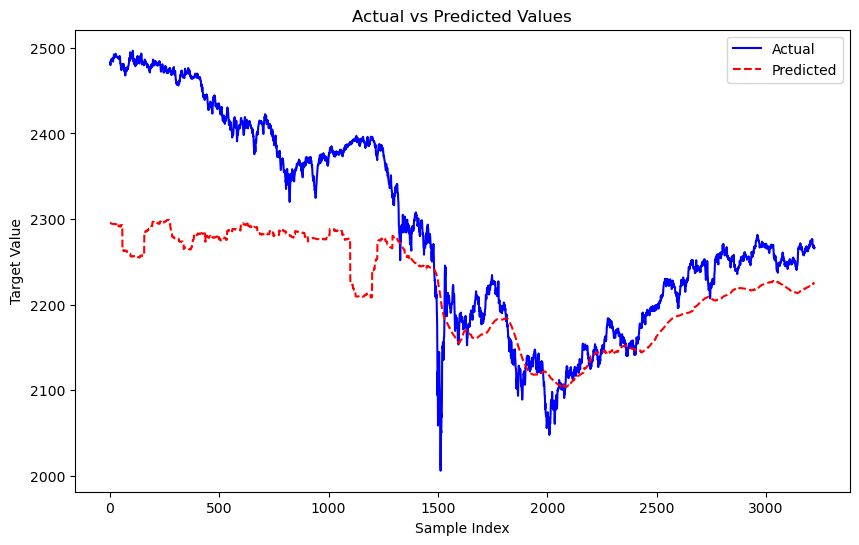

metrics for  lvl -  3 window -  100 c -  0.05 ofi -  False


2024-12-07 10:14:51.473078: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 10:14:51.746433: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Squared Error: 7353.353431866378
R² Score: 0.47917379576003805


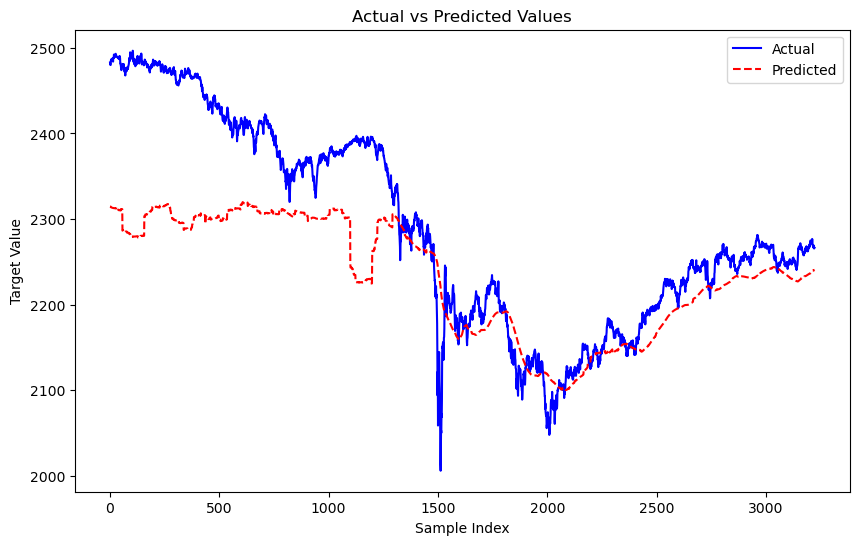

metrics for  lvl -  5 window -  100 c -  0.05 ofi -  True


2024-12-07 10:39:16.331139: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-07 10:39:16.821352: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
ofi_flag = [True, False]
window_size = [25, 50, 100]
lvls = [3, 5, 10]
C = [1, 10, 0.1, 0.05]

for c in C:
    for wd in window_size:
        for lvl in lvls:
            for ofi in ofi_flag:
                print("metrics for ", "lvl - ", lvl, "window - ", wd, "c - ", c, "ofi - " ,ofi)
                train_model_and_get_result(lvl, wd, c, ofi)

In [ ]:
train_model_and_get_result(10, 25, False)

In [ ]:
y_pred = knn.predict(X_test_scaled)
dp.get_metrics(y_test, y_pred)

In [ ]:
df_one = dp.get_bid_levels(df, 5)
df_one.head()

df_two = dp.get_bid_with_ofi_levels(df_one, 5)

In [ ]:
# Set window size
window_size = 40

# Drop time column (not needed for input features)
df_two = df_two.drop(columns=["time"])

# Split dataset into train and test sets
data_length = df_two.shape[0]
train_length = round(0.8 * data_length)  # 80% training data
normalized_df = dp.normalize_data(df_two, train_length)

data_array = normalized_df.to_numpy()

X = data_array[:, 1:]  # All columns except the first ('midpoint')
y = df_two["midpoint"]
#y = data_array[:, 0]   # The first column is 'midpoint'

windows_train = timeseries_dataset_from_array(
    X[:train_length],                    # Features for training
    y[window_size:(train_length+window_size)],  # Target (midpoint) for training
    sequence_length=window_size,        # Length of each input sequence
    sequence_stride=1,                  # Step size for creating sequences
    sampling_rate=1,                    # Sample every time step
    batch_size=64,                      # Batch size
    shuffle=False                        # Shuffle training data
)

# Windows for test dataset
windows_test = timeseries_dataset_from_array(
    X[train_length:(data_length-window_size)],  # Features for testing
    y[train_length + window_size:],            # Target (midpoint) for testing
    sequence_length=window_size,               # Length of each input sequence
    sequence_stride=1,                         # Step size for creating sequences
    sampling_rate=1,                           # Sample every time step
    batch_size=64,                             # Batch size
    shuffle=False                              # Do not shuffle test data
)

In [ ]:
import numpy as np

# Extract training data
X_train, y_train = dp.extract_data_from_dataset(windows_train)

# Extract testing data
X_test, y_test = dp.extract_data_from_dataset(windows_test)


In [ ]:
from sklearn.preprocessing import StandardScaler
# Flatten training and testing data
X_train_flat = X_train.reshape(X_train.shape[0], -1)  # Flatten each window
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Initialize scaler
scaler = StandardScaler()

# Fit and transform training data
X_train_scaled = scaler.fit_transform(X_train_flat)

# Transform testing data
X_test_scaled = scaler.transform(X_test_flat)


In [ ]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=8)

knn.fit(X_train_scaled, y_train)

In [ ]:


# Predict on the test set
y_pred = knn.predict(X_test_scaled)
dp.get_metrics(y_test, y_pred)

In [ ]:
Slides
LOB intro
Data preprocessing and Inputs
Models
Metrics and Results
Novelty



Models
1. Results - different lvls 3, ,5, 10 - with ofi , without ofi
Graph
MSE
R2

Horizon